# Load Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns

In [2]:
list_of_architectures = [
    "Xception",
    "VGG16",
    "VGG19",
    "ResNet50",
    "ResNet101",
    "ResNet152",
    "ResNet50V2",
    "ResNet101V2",
    "ResNet152V2",
    "InceptionV3",
    "InceptionResNetV2",
    "MobileNet",
    "MobileNetV2",
    "DenseNet121",
    "DenseNet169",
    "DenseNet201"
    
]

In [3]:
list_of_classifiers = [
    "RF",
    "SVM"
]

In [4]:
list_of_size = [
    128,
    256
]

In [5]:
layer = "last_layer"

In [6]:
preprocessing_technique = "smote"

In [7]:
output_folder = "output"
analysis_output =  output_folder + "/" + layer + "_" + preprocessing_technique + "_RF_SVM_128_256.csv"

# get Data

In [8]:
def getData(model, image_size):
    train_data_dir="../class_imabalance/" + layer + "/" + str(image_size)+"/"
    test_data_dir="../feature_extractor/" + layer + "/" + str(image_size)+"/"
    #print(os.listdir(train_data_dir))
    #print(os.listdir(test_data_dir))
    X_train=np.load(train_data_dir+model+"_X_train_SMOTE.npy")
    y_train=np.load(train_data_dir+model+"_y_train_SMOTE.npy")
    X_test=np.load(test_data_dir+model+"_test_images.npy")
    y_test=np.load(test_data_dir+"test_labels.npy")
    return X_train, y_train, X_test, y_test

In [9]:
def getLabelEncoder(layer, image_size):
    label_encoder_location = "../feature_extractor/" + layer + "/" + str(image_size)+"/"
    label_encoder = np.load(label_encoder_location+'label_encoder.npy')
    return label_encoder

#  Reusable function for Confusion Matrix 

In [10]:
def getClassificationReport(test_labels, prediction):
    
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        import itertools
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        #print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        #plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
        
    from sklearn.metrics import confusion_matrix
    test_label_list=list(np.unique(test_labels))
    cnf_matrix = confusion_matrix(test_labels, prediction,labels=test_label_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cnf_matrix, classes=test_label_list,
                          title='Confusion matrix, without normalization')
    
    
    from sklearn import metrics
    
    accuracy = round(metrics.accuracy_score(test_labels, prediction),3)
    precision = round(metrics.precision_score(test_labels, prediction, average='weighted'),3)
    recall = round(metrics.recall_score(test_labels, prediction, average='weighted'),3)
    f1_score = round(metrics.f1_score(test_labels, prediction, average='weighted'),3)
    
    # Balanced
    balanced_accuracy = round(metrics.balanced_accuracy_score(test_labels, prediction),3)
    
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round((TP/(TP+FN)).mean(),3)
    # Specificity or true negative rate
    TNR = round((TN/(TN+FP) ).mean(),3)
    # Precision or positive predictive value
    PPV = round((TP/(TP+FP)).mean(),3)
    # Negative predictive value
    NPV = round((TN/(TN+FN)).mean(),3)
    # Fall out or false positive rate
    FPR = round((FP/(FP+TN)).mean(),3)
    # False negative rate
    FNR = round((FN/(TP+FN)).mean(),3)
    # False discovery rate
    FDR = round((FP/(TP+FP)).mean(),3)

    # Overall accuracy
    Overall_Acc = round(((TP+TN)/(TP+FP+FN+TN)).mean(),3)
    Bal_F1 = round((2*(PPV*TPR)/(PPV+TPR)),3)
    
    
    print("Acc     = ", accuracy)
    print("Pre     = ", precision)
    print("Rec     = ", recall)
    print("F1      = ", f1_score)
    print("")
    
    print("Bal_Acc = ", balanced_accuracy)
    print("Bal_Pre = ", PPV)
    print("Bal_Rec = ", TPR)
    print("Bal_F1  = ", Bal_F1)
    print("")
    
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(test_labels, prediction))
    
    return accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc


# Classifier

In [11]:
def classify(model_name, classifier, image_size):
    X_train, y_train, X_test, y_test = getData(model_name, image_size)

    if classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators = 100, random_state = 42)
    elif classifier == "SVM":
        from sklearn.svm import SVC
        model = SVC(kernel='linear', degree=3, C=1, decision_function_shape='ovo')
        
    # Train the model on training data
    model.fit(X_train, y_train) #For sklearn no one hot encoding

    #Now predict using the trained RF model. 
    prediction = model.predict(X_test)
    
    #get the encoder from the pickle file
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.classes_ = getLabelEncoder(layer, image_size)
    
    import pickle
    model_loc = "models"
    filename = model_loc + "/" + layer + "_" + preprocessing_technique + "_" + 'classifier'  + "_" + model_name + "_" + classifier + "_" + str(image_size) + " .sav "
    pickle.dump(model, open(filename, 'wb'))
    
    #Inverse le transform to get original label back. 
    prediction = le.inverse_transform(prediction)
    y_test = le.inverse_transform(y_test)
    
    accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc = getClassificationReport(y_test, prediction)
    return accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc

--------------------------------------------------------------------------
RF - Xception - 128

Confusion matrix, without normalization


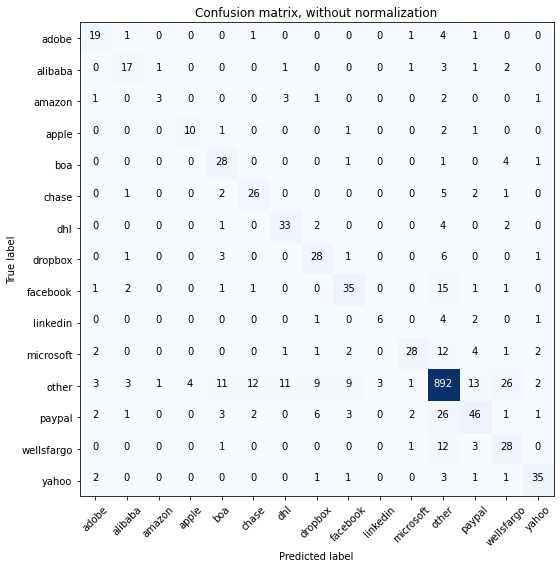

Acc     =  0.802
Pre     =  0.81
Rec     =  0.802
F1      =  0.802

Bal_Acc =  0.644
Bal_Pre =  0.659
Bal_Rec =  0.644
Bal_F1  =  0.651

              precision    recall  f1-score   support

       adobe       0.63      0.70      0.67        27
     alibaba       0.65      0.65      0.65        26
      amazon       0.60      0.27      0.37        11
       apple       0.71      0.67      0.69        15
         boa       0.55      0.80      0.65        35
       chase       0.62      0.70      0.66        37
         dhl       0.67      0.79      0.73        42
     dropbox       0.57      0.70      0.63        40
    facebook       0.66      0.61      0.64        57
    linkedin       0.67      0.43      0.52        14
   microsoft       0.82      0.53      0.64        53
       other       0.90      0.89      0.90      1000
      paypal       0.61      0.49      0.55        93
  wellsfargo       0.42      0.62      0.50        45
       yahoo       0.80      0.80      0.80        4

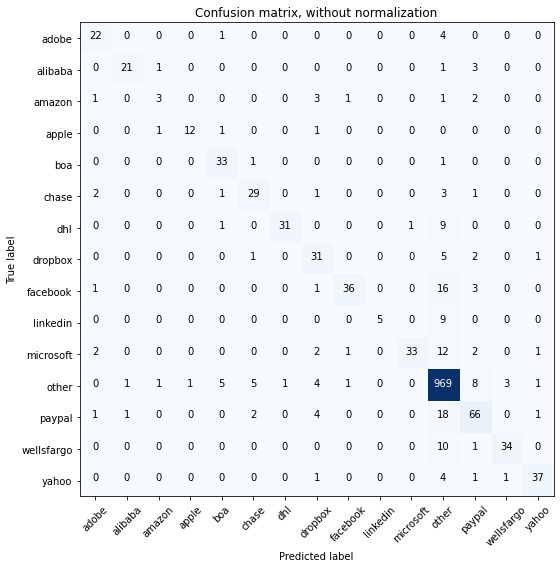

Acc     =  0.885
Pre     =  0.887
Rec     =  0.885
F1      =  0.88

Bal_Acc =  0.721
Bal_Pre =  0.84
Bal_Rec =  0.721
Bal_F1  =  0.776

              precision    recall  f1-score   support

       adobe       0.76      0.81      0.79        27
     alibaba       0.91      0.81      0.86        26
      amazon       0.50      0.27      0.35        11
       apple       0.92      0.80      0.86        15
         boa       0.79      0.94      0.86        35
       chase       0.76      0.78      0.77        37
         dhl       0.97      0.74      0.84        42
     dropbox       0.65      0.78      0.70        40
    facebook       0.92      0.63      0.75        57
    linkedin       1.00      0.36      0.53        14
   microsoft       0.97      0.62      0.76        53
       other       0.91      0.97      0.94      1000
      paypal       0.74      0.71      0.73        93
  wellsfargo       0.89      0.76      0.82        45
       yahoo       0.90      0.84      0.87        44

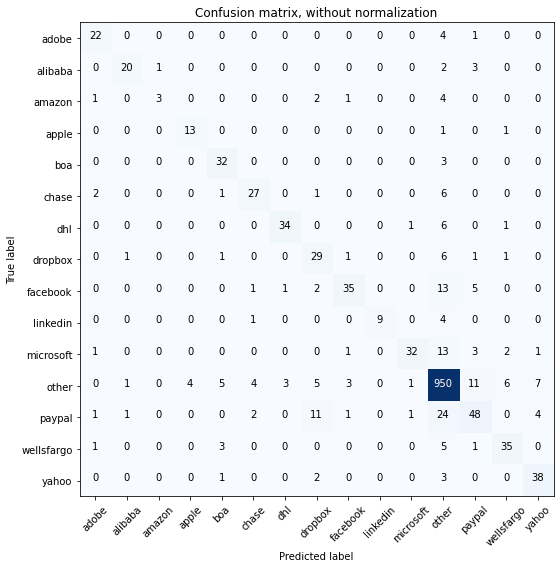

Acc     =  0.862
Pre     =  0.862
Rec     =  0.862
F1      =  0.858

Bal_Acc =  0.725
Bal_Pre =  0.798
Bal_Rec =  0.725
Bal_F1  =  0.76

              precision    recall  f1-score   support

       adobe       0.79      0.81      0.80        27
     alibaba       0.87      0.77      0.82        26
      amazon       0.75      0.27      0.40        11
       apple       0.76      0.87      0.81        15
         boa       0.74      0.91      0.82        35
       chase       0.77      0.73      0.75        37
         dhl       0.89      0.81      0.85        42
     dropbox       0.56      0.72      0.63        40
    facebook       0.83      0.61      0.71        57
    linkedin       1.00      0.64      0.78        14
   microsoft       0.91      0.60      0.73        53
       other       0.91      0.95      0.93      1000
      paypal       0.66      0.52      0.58        93
  wellsfargo       0.76      0.78      0.77        45
       yahoo       0.76      0.86      0.81        4

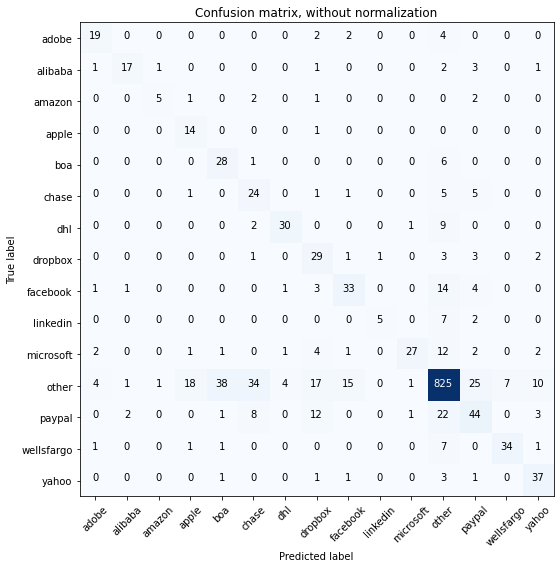

Acc     =  0.761
Pre     =  0.802
Rec     =  0.761
F1      =  0.772

Bal_Acc =  0.665
Bal_Pre =  0.652
Bal_Rec =  0.665
Bal_F1  =  0.658

              precision    recall  f1-score   support

       adobe       0.68      0.70      0.69        27
     alibaba       0.81      0.65      0.72        26
      amazon       0.71      0.45      0.56        11
       apple       0.39      0.93      0.55        15
         boa       0.40      0.80      0.53        35
       chase       0.33      0.65      0.44        37
         dhl       0.83      0.71      0.77        42
     dropbox       0.40      0.72      0.52        40
    facebook       0.61      0.58      0.59        57
    linkedin       0.83      0.36      0.50        14
   microsoft       0.90      0.51      0.65        53
       other       0.90      0.82      0.86      1000
      paypal       0.48      0.47      0.48        93
  wellsfargo       0.83      0.76      0.79        45
       yahoo       0.66      0.84      0.74        

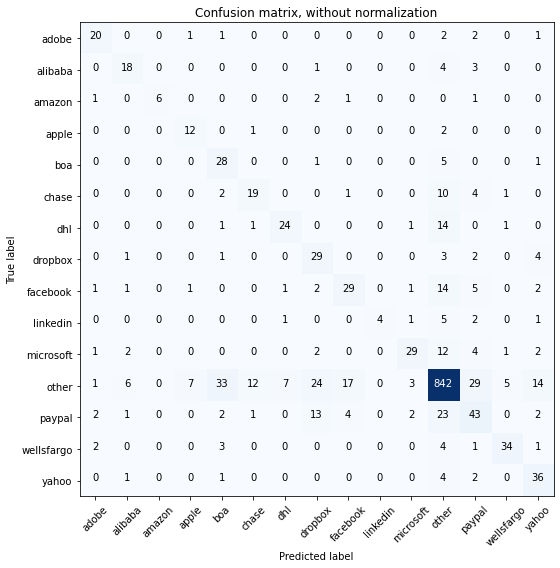

Acc     =  0.762
Pre     =  0.79
Rec     =  0.762
F1      =  0.769

Bal_Acc =  0.641
Bal_Pre =  0.666
Bal_Rec =  0.641
Bal_F1  =  0.653

              precision    recall  f1-score   support

       adobe       0.71      0.74      0.73        27
     alibaba       0.60      0.69      0.64        26
      amazon       1.00      0.55      0.71        11
       apple       0.57      0.80      0.67        15
         boa       0.39      0.80      0.52        35
       chase       0.56      0.51      0.54        37
         dhl       0.73      0.57      0.64        42
     dropbox       0.39      0.72      0.51        40
    facebook       0.56      0.51      0.53        57
    linkedin       1.00      0.29      0.44        14
   microsoft       0.78      0.55      0.64        53
       other       0.89      0.84      0.87      1000
      paypal       0.44      0.46      0.45        93
  wellsfargo       0.81      0.76      0.78        45
       yahoo       0.56      0.82      0.67        4

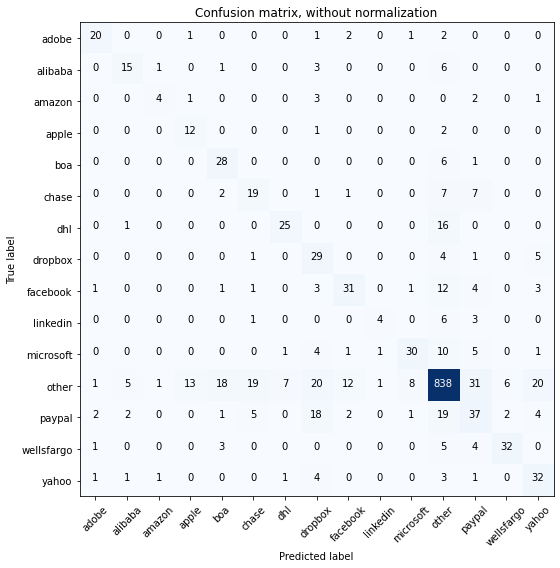

Acc     =  0.751
Pre     =  0.78
Rec     =  0.751
F1      =  0.759

Bal_Acc =  0.612
Bal_Pre =  0.6
Bal_Rec =  0.612
Bal_F1  =  0.606

              precision    recall  f1-score   support

       adobe       0.77      0.74      0.75        27
     alibaba       0.62      0.58      0.60        26
      amazon       0.57      0.36      0.44        11
       apple       0.44      0.80      0.57        15
         boa       0.52      0.80      0.63        35
       chase       0.41      0.51      0.46        37
         dhl       0.74      0.60      0.66        42
     dropbox       0.33      0.72      0.46        40
    facebook       0.63      0.54      0.58        57
    linkedin       0.67      0.29      0.40        14
   microsoft       0.73      0.57      0.64        53
       other       0.90      0.84      0.87      1000
      paypal       0.39      0.40      0.39        93
  wellsfargo       0.80      0.71      0.75        45
       yahoo       0.48      0.73      0.58        44


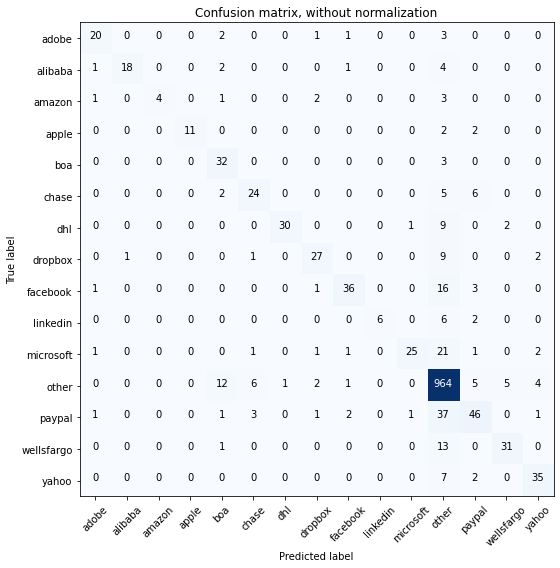

Acc     =  0.851
Pre     =  0.853
Rec     =  0.851
F1      =  0.842

Bal_Acc =  0.664
Bal_Pre =  0.849
Bal_Rec =  0.664
Bal_F1  =  0.745

              precision    recall  f1-score   support

       adobe       0.80      0.74      0.77        27
     alibaba       0.95      0.69      0.80        26
      amazon       1.00      0.36      0.53        11
       apple       1.00      0.73      0.85        15
         boa       0.60      0.91      0.73        35
       chase       0.69      0.65      0.67        37
         dhl       0.97      0.71      0.82        42
     dropbox       0.77      0.68      0.72        40
    facebook       0.86      0.63      0.73        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.93      0.47      0.62        53
       other       0.87      0.96      0.92      1000
      paypal       0.69      0.49      0.58        93
  wellsfargo       0.82      0.69      0.75        45
       yahoo       0.80      0.80      0.80        

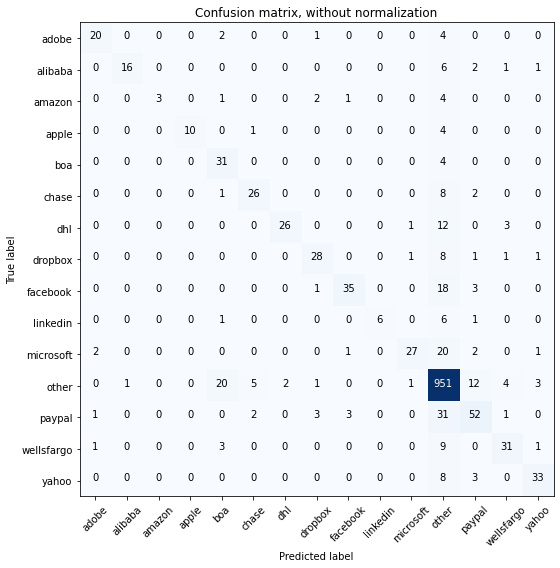

Acc     =  0.841
Pre     =  0.847
Rec     =  0.841
F1      =  0.835

Bal_Acc =  0.647
Bal_Pre =  0.844
Bal_Rec =  0.647
Bal_F1  =  0.732

              precision    recall  f1-score   support

       adobe       0.83      0.74      0.78        27
     alibaba       0.94      0.62      0.74        26
      amazon       1.00      0.27      0.43        11
       apple       1.00      0.67      0.80        15
         boa       0.53      0.89      0.66        35
       chase       0.76      0.70      0.73        37
         dhl       0.93      0.62      0.74        42
     dropbox       0.78      0.70      0.74        40
    facebook       0.88      0.61      0.72        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.90      0.51      0.65        53
       other       0.87      0.95      0.91      1000
      paypal       0.67      0.56      0.61        93
  wellsfargo       0.76      0.69      0.72        45
       yahoo       0.82      0.75      0.79        

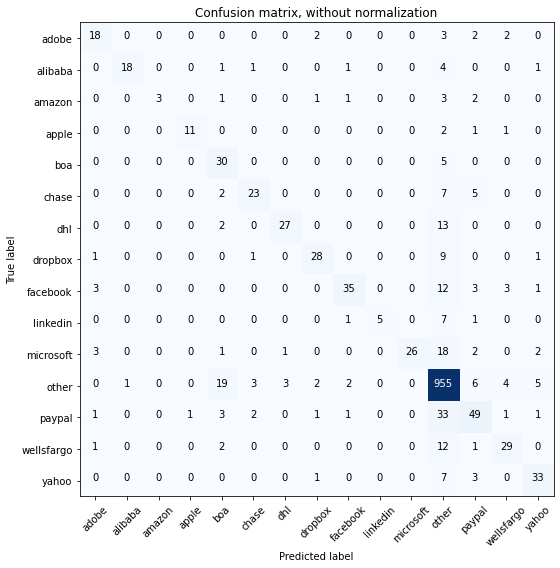

Acc     =  0.838
Pre     =  0.845
Rec     =  0.838
F1      =  0.831

Bal_Acc =  0.635
Bal_Pre =  0.821
Bal_Rec =  0.635
Bal_F1  =  0.716

              precision    recall  f1-score   support

       adobe       0.67      0.67      0.67        27
     alibaba       0.95      0.69      0.80        26
      amazon       1.00      0.27      0.43        11
       apple       0.92      0.73      0.81        15
         boa       0.49      0.86      0.62        35
       chase       0.77      0.62      0.69        37
         dhl       0.87      0.64      0.74        42
     dropbox       0.80      0.70      0.75        40
    facebook       0.85      0.61      0.71        57
    linkedin       1.00      0.36      0.53        14
   microsoft       1.00      0.49      0.66        53
       other       0.88      0.95      0.91      1000
      paypal       0.65      0.53      0.58        93
  wellsfargo       0.72      0.64      0.68        45
       yahoo       0.75      0.75      0.75        

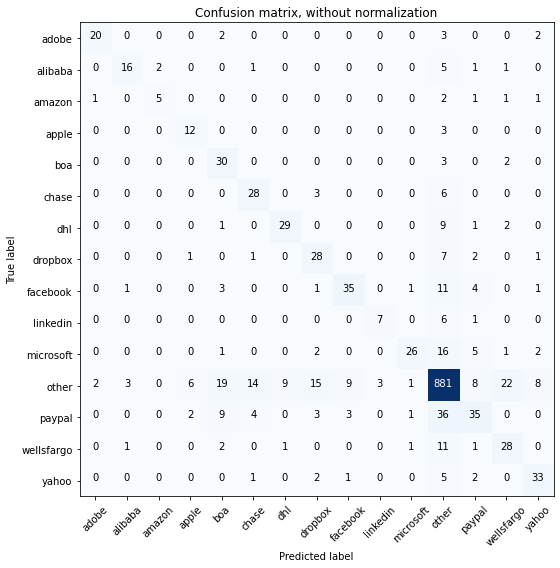

Acc     =  0.788
Pre     =  0.799
Rec     =  0.788
F1      =  0.787

Bal_Acc =  0.657
Bal_Pre =  0.675
Bal_Rec =  0.657
Bal_F1  =  0.666

              precision    recall  f1-score   support

       adobe       0.87      0.74      0.80        27
     alibaba       0.76      0.62      0.68        26
      amazon       0.71      0.45      0.56        11
       apple       0.57      0.80      0.67        15
         boa       0.45      0.86      0.59        35
       chase       0.57      0.76      0.65        37
         dhl       0.74      0.69      0.72        42
     dropbox       0.52      0.70      0.60        40
    facebook       0.73      0.61      0.67        57
    linkedin       0.70      0.50      0.58        14
   microsoft       0.87      0.49      0.63        53
       other       0.88      0.88      0.88      1000
      paypal       0.57      0.38      0.45        93
  wellsfargo       0.49      0.62      0.55        45
       yahoo       0.69      0.75      0.72        

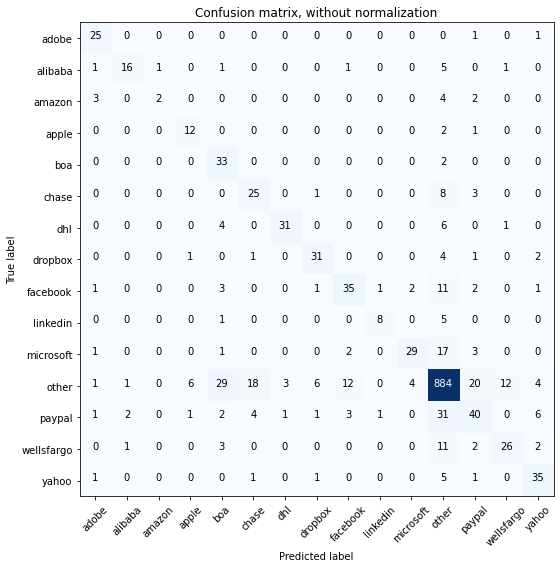

Acc     =  0.801
Pre     =  0.811
Rec     =  0.801
F1      =  0.8

Bal_Acc =  0.672
Bal_Pre =  0.695
Bal_Rec =  0.672
Bal_F1  =  0.683

              precision    recall  f1-score   support

       adobe       0.74      0.93      0.82        27
     alibaba       0.80      0.62      0.70        26
      amazon       0.67      0.18      0.29        11
       apple       0.60      0.80      0.69        15
         boa       0.43      0.94      0.59        35
       chase       0.51      0.68      0.58        37
         dhl       0.89      0.74      0.81        42
     dropbox       0.76      0.78      0.77        40
    facebook       0.66      0.61      0.64        57
    linkedin       0.80      0.57      0.67        14
   microsoft       0.83      0.55      0.66        53
       other       0.89      0.88      0.89      1000
      paypal       0.53      0.43      0.47        93
  wellsfargo       0.65      0.58      0.61        45
       yahoo       0.69      0.80      0.74        44

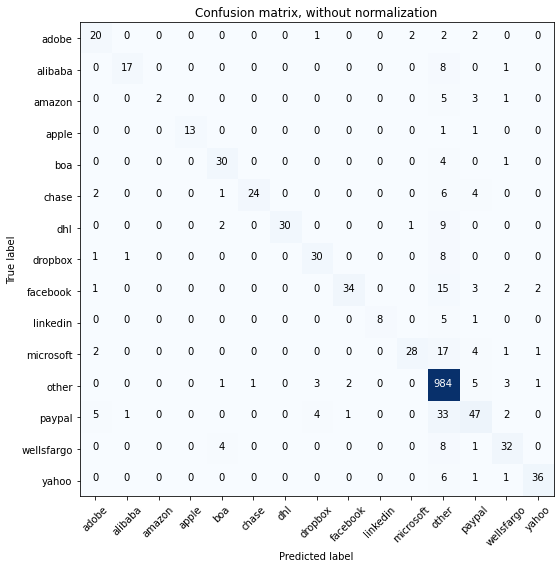

Acc     =  0.867
Pre     =  0.868
Rec     =  0.867
F1      =  0.858

Bal_Acc =  0.675
Bal_Pre =  0.871
Bal_Rec =  0.675
Bal_F1  =  0.761

              precision    recall  f1-score   support

       adobe       0.65      0.74      0.69        27
     alibaba       0.89      0.65      0.76        26
      amazon       1.00      0.18      0.31        11
       apple       1.00      0.87      0.93        15
         boa       0.79      0.86      0.82        35
       chase       0.96      0.65      0.77        37
         dhl       1.00      0.71      0.83        42
     dropbox       0.79      0.75      0.77        40
    facebook       0.92      0.60      0.72        57
    linkedin       1.00      0.57      0.73        14
   microsoft       0.90      0.53      0.67        53
       other       0.89      0.98      0.93      1000
      paypal       0.65      0.51      0.57        93
  wellsfargo       0.73      0.71      0.72        45
       yahoo       0.90      0.82      0.86        

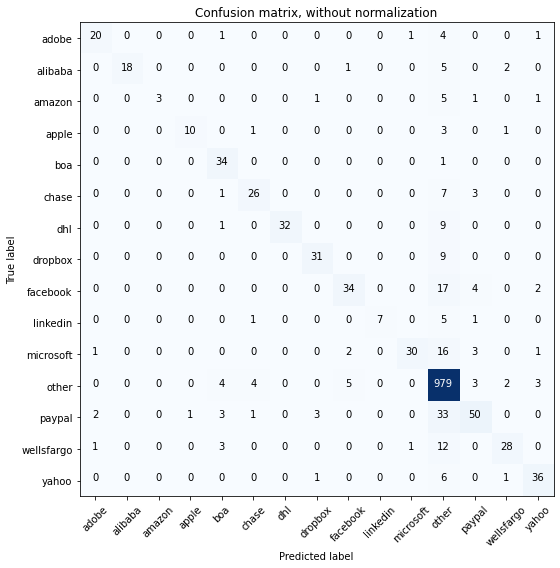

Acc     =  0.869
Pre     =  0.87
Rec     =  0.869
F1      =  0.861

Bal_Acc =  0.68
Bal_Pre =  0.877
Bal_Rec =  0.68
Bal_F1  =  0.766

              precision    recall  f1-score   support

       adobe       0.83      0.74      0.78        27
     alibaba       1.00      0.69      0.82        26
      amazon       1.00      0.27      0.43        11
       apple       0.91      0.67      0.77        15
         boa       0.72      0.97      0.83        35
       chase       0.79      0.70      0.74        37
         dhl       1.00      0.76      0.86        42
     dropbox       0.86      0.78      0.82        40
    facebook       0.81      0.60      0.69        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.94      0.57      0.71        53
       other       0.88      0.98      0.93      1000
      paypal       0.77      0.54      0.63        93
  wellsfargo       0.82      0.62      0.71        45
       yahoo       0.82      0.82      0.82        44


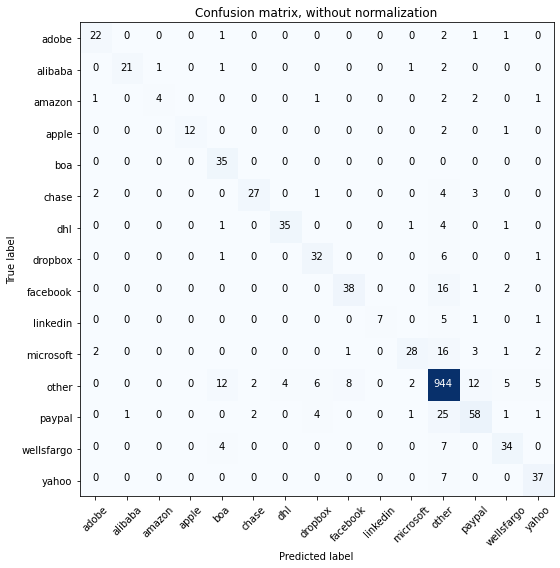

Acc     =  0.867
Pre     =  0.869
Rec     =  0.867
F1      =  0.863

Bal_Acc =  0.734
Bal_Pre =  0.833
Bal_Rec =  0.734
Bal_F1  =  0.78

              precision    recall  f1-score   support

       adobe       0.81      0.81      0.81        27
     alibaba       0.95      0.81      0.88        26
      amazon       0.80      0.36      0.50        11
       apple       1.00      0.80      0.89        15
         boa       0.64      1.00      0.78        35
       chase       0.87      0.73      0.79        37
         dhl       0.90      0.83      0.86        42
     dropbox       0.73      0.80      0.76        40
    facebook       0.81      0.67      0.73        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.85      0.53      0.65        53
       other       0.91      0.94      0.92      1000
      paypal       0.72      0.62      0.67        93
  wellsfargo       0.74      0.76      0.75        45
       yahoo       0.77      0.84      0.80        4

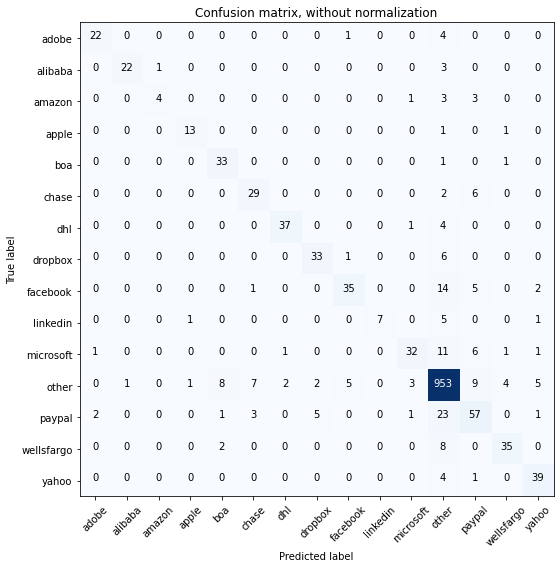

Acc     =  0.878
Pre     =  0.877
Rec     =  0.878
F1      =  0.874

Bal_Acc =  0.751
Bal_Pre =  0.84
Bal_Rec =  0.751
Bal_F1  =  0.793

              precision    recall  f1-score   support

       adobe       0.88      0.81      0.85        27
     alibaba       0.96      0.85      0.90        26
      amazon       0.80      0.36      0.50        11
       apple       0.87      0.87      0.87        15
         boa       0.75      0.94      0.84        35
       chase       0.72      0.78      0.75        37
         dhl       0.93      0.88      0.90        42
     dropbox       0.82      0.82      0.82        40
    facebook       0.83      0.61      0.71        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.84      0.60      0.70        53
       other       0.91      0.95      0.93      1000
      paypal       0.66      0.61      0.63        93
  wellsfargo       0.83      0.78      0.80        45
       yahoo       0.80      0.89      0.84        4

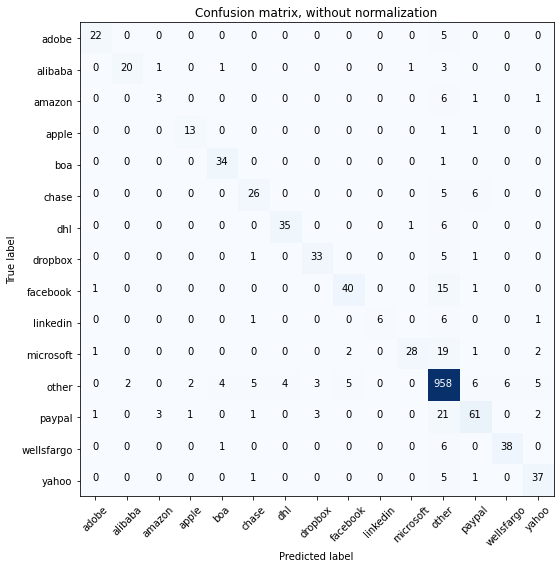

Acc     =  0.88
Pre     =  0.878
Rec     =  0.88
F1      =  0.875

Bal_Acc =  0.734
Bal_Pre =  0.831
Bal_Rec =  0.734
Bal_F1  =  0.779

              precision    recall  f1-score   support

       adobe       0.88      0.81      0.85        27
     alibaba       0.91      0.77      0.83        26
      amazon       0.43      0.27      0.33        11
       apple       0.81      0.87      0.84        15
         boa       0.85      0.97      0.91        35
       chase       0.74      0.70      0.72        37
         dhl       0.90      0.83      0.86        42
     dropbox       0.85      0.82      0.84        40
    facebook       0.85      0.70      0.77        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.93      0.53      0.67        53
       other       0.90      0.96      0.93      1000
      paypal       0.77      0.66      0.71        93
  wellsfargo       0.86      0.84      0.85        45
       yahoo       0.77      0.84      0.80        44

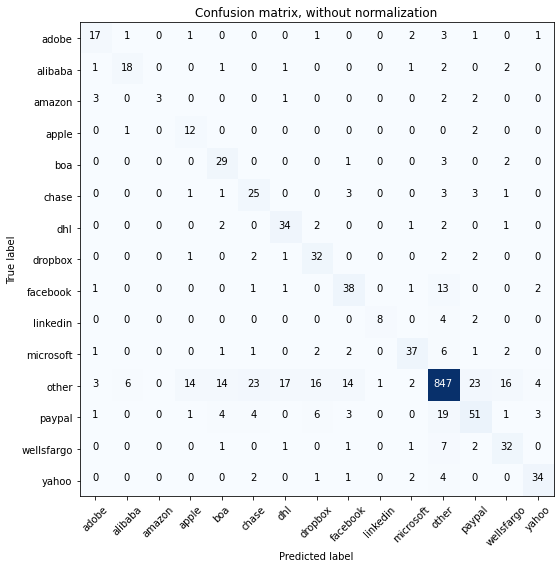

Acc     =  0.791
Pre     =  0.818
Rec     =  0.791
F1      =  0.798

Bal_Acc =  0.688
Bal_Pre =  0.663
Bal_Rec =  0.688
Bal_F1  =  0.675

              precision    recall  f1-score   support

       adobe       0.63      0.63      0.63        27
     alibaba       0.69      0.69      0.69        26
      amazon       1.00      0.27      0.43        11
       apple       0.40      0.80      0.53        15
         boa       0.55      0.83      0.66        35
       chase       0.43      0.68      0.53        37
         dhl       0.61      0.81      0.69        42
     dropbox       0.53      0.80      0.64        40
    facebook       0.60      0.67      0.63        57
    linkedin       0.89      0.57      0.70        14
   microsoft       0.79      0.70      0.74        53
       other       0.92      0.85      0.88      1000
      paypal       0.57      0.55      0.56        93
  wellsfargo       0.56      0.71      0.63        45
       yahoo       0.77      0.77      0.77        

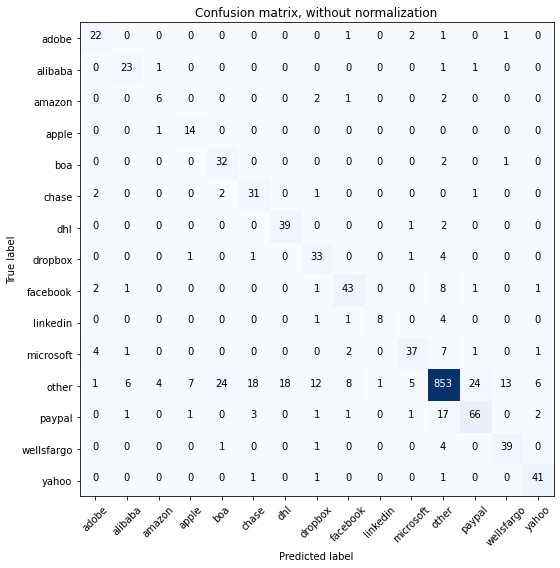

Acc     =  0.836
Pre     =  0.857
Rec     =  0.836
F1      =  0.841

Bal_Acc =  0.805
Bal_Pre =  0.704
Bal_Rec =  0.805
Bal_F1  =  0.751

              precision    recall  f1-score   support

       adobe       0.71      0.81      0.76        27
     alibaba       0.72      0.88      0.79        26
      amazon       0.50      0.55      0.52        11
       apple       0.61      0.93      0.74        15
         boa       0.54      0.91      0.68        35
       chase       0.57      0.84      0.68        37
         dhl       0.68      0.93      0.79        42
     dropbox       0.62      0.82      0.71        40
    facebook       0.75      0.75      0.75        57
    linkedin       0.89      0.57      0.70        14
   microsoft       0.79      0.70      0.74        53
       other       0.94      0.85      0.90      1000
      paypal       0.70      0.71      0.71        93
  wellsfargo       0.72      0.87      0.79        45
       yahoo       0.80      0.93      0.86        

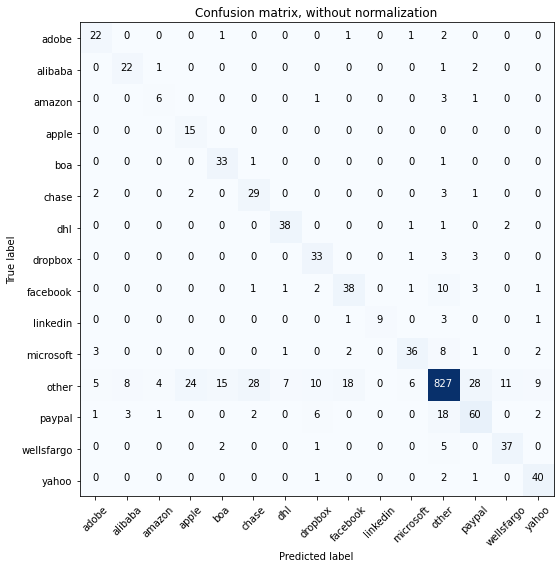

Acc     =  0.809
Pre     =  0.838
Rec     =  0.809
F1      =  0.817

Bal_Acc =  0.79
Bal_Pre =  0.677
Bal_Rec =  0.79
Bal_F1  =  0.729

              precision    recall  f1-score   support

       adobe       0.67      0.81      0.73        27
     alibaba       0.67      0.85      0.75        26
      amazon       0.50      0.55      0.52        11
       apple       0.37      1.00      0.54        15
         boa       0.65      0.94      0.77        35
       chase       0.48      0.78      0.59        37
         dhl       0.81      0.90      0.85        42
     dropbox       0.61      0.82      0.70        40
    facebook       0.63      0.67      0.65        57
    linkedin       1.00      0.64      0.78        14
   microsoft       0.78      0.68      0.73        53
       other       0.93      0.83      0.88      1000
      paypal       0.60      0.65      0.62        93
  wellsfargo       0.74      0.82      0.78        45
       yahoo       0.73      0.91      0.81        44

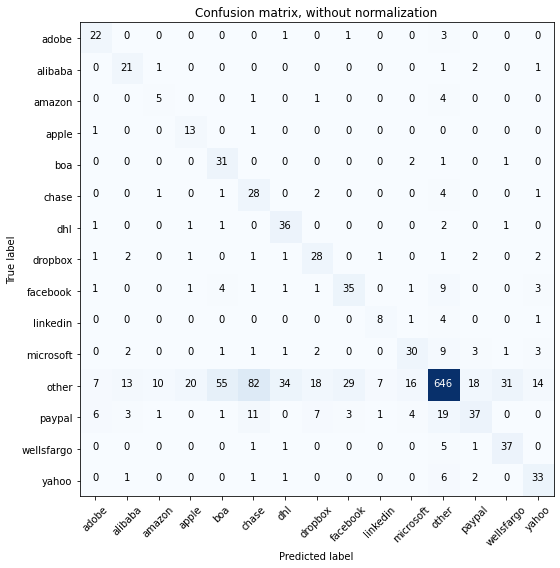

Acc     =  0.656
Pre     =  0.758
Rec     =  0.656
F1      =  0.68

Bal_Acc =  0.701
Bal_Pre =  0.487
Bal_Rec =  0.701
Bal_F1  =  0.575

              precision    recall  f1-score   support

       adobe       0.56      0.81      0.67        27
     alibaba       0.50      0.81      0.62        26
      amazon       0.28      0.45      0.34        11
       apple       0.36      0.87      0.51        15
         boa       0.33      0.89      0.48        35
       chase       0.22      0.76      0.34        37
         dhl       0.47      0.86      0.61        42
     dropbox       0.47      0.70      0.57        40
    facebook       0.51      0.61      0.56        57
    linkedin       0.47      0.57      0.52        14
   microsoft       0.56      0.57      0.56        53
       other       0.90      0.65      0.75      1000
      paypal       0.57      0.40      0.47        93
  wellsfargo       0.52      0.82      0.64        45
       yahoo       0.57      0.75      0.65        4

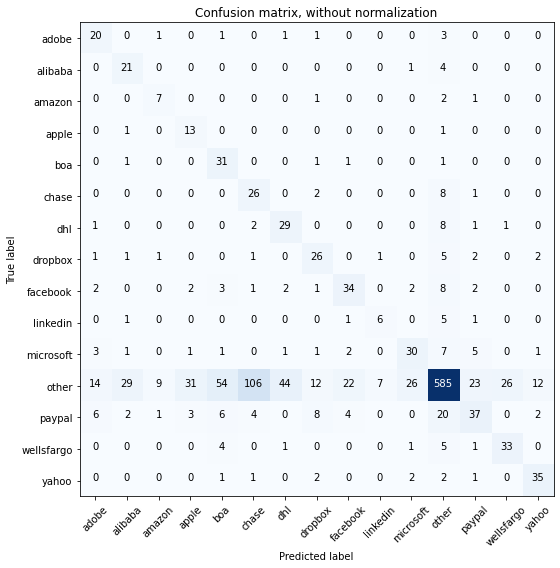

Acc     =  0.606
Pre     =  0.731
Rec     =  0.606
F1      =  0.635

Bal_Acc =  0.672
Bal_Pre =  0.453
Bal_Rec =  0.672
Bal_F1  =  0.541

              precision    recall  f1-score   support

       adobe       0.43      0.74      0.54        27
     alibaba       0.37      0.81      0.51        26
      amazon       0.37      0.64      0.47        11
       apple       0.26      0.87      0.40        15
         boa       0.31      0.89      0.46        35
       chase       0.18      0.70      0.29        37
         dhl       0.37      0.69      0.48        42
     dropbox       0.47      0.65      0.55        40
    facebook       0.53      0.60      0.56        57
    linkedin       0.43      0.43      0.43        14
   microsoft       0.48      0.57      0.52        53
       other       0.88      0.58      0.70      1000
      paypal       0.49      0.40      0.44        93
  wellsfargo       0.55      0.73      0.63        45
       yahoo       0.67      0.80      0.73        

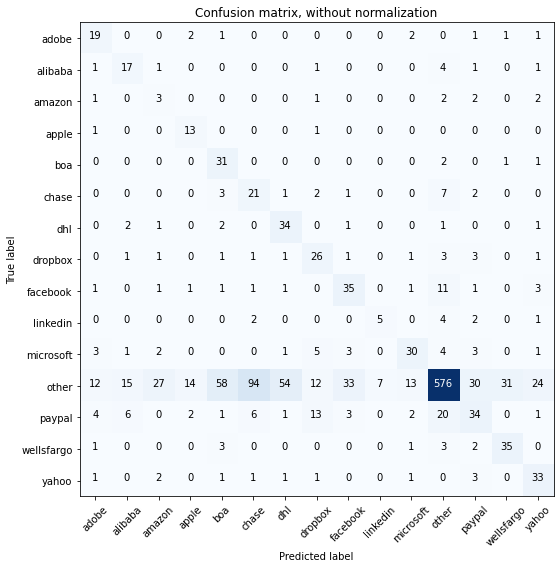

Acc     =  0.593
Pre     =  0.732
Rec     =  0.593
F1      =  0.625

Bal_Acc =  0.628
Bal_Pre =  0.422
Bal_Rec =  0.628
Bal_F1  =  0.505

              precision    recall  f1-score   support

       adobe       0.43      0.70      0.54        27
     alibaba       0.40      0.65      0.50        26
      amazon       0.08      0.27      0.12        11
       apple       0.41      0.87      0.55        15
         boa       0.30      0.89      0.45        35
       chase       0.17      0.57      0.26        37
         dhl       0.36      0.81      0.50        42
     dropbox       0.42      0.65      0.51        40
    facebook       0.45      0.61      0.52        57
    linkedin       0.42      0.36      0.38        14
   microsoft       0.59      0.57      0.58        53
       other       0.90      0.58      0.70      1000
      paypal       0.40      0.37      0.38        93
  wellsfargo       0.51      0.78      0.62        45
       yahoo       0.47      0.75      0.58        

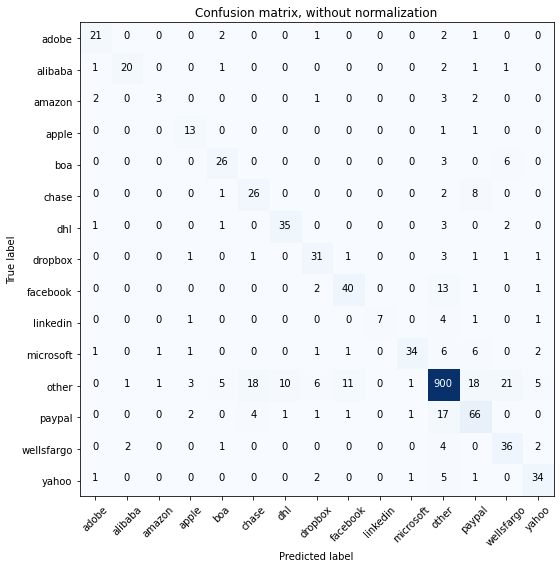

Acc     =  0.84
Pre     =  0.852
Rec     =  0.84
F1      =  0.842

Bal_Acc =  0.718
Bal_Pre =  0.735
Bal_Rec =  0.718
Bal_F1  =  0.726

              precision    recall  f1-score   support

       adobe       0.78      0.78      0.78        27
     alibaba       0.87      0.77      0.82        26
      amazon       0.60      0.27      0.37        11
       apple       0.62      0.87      0.72        15
         boa       0.70      0.74      0.72        35
       chase       0.53      0.70      0.60        37
         dhl       0.76      0.83      0.80        42
     dropbox       0.69      0.78      0.73        40
    facebook       0.74      0.70      0.72        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.92      0.64      0.76        53
       other       0.93      0.90      0.91      1000
      paypal       0.62      0.71      0.66        93
  wellsfargo       0.54      0.80      0.64        45
       yahoo       0.74      0.77      0.76        44

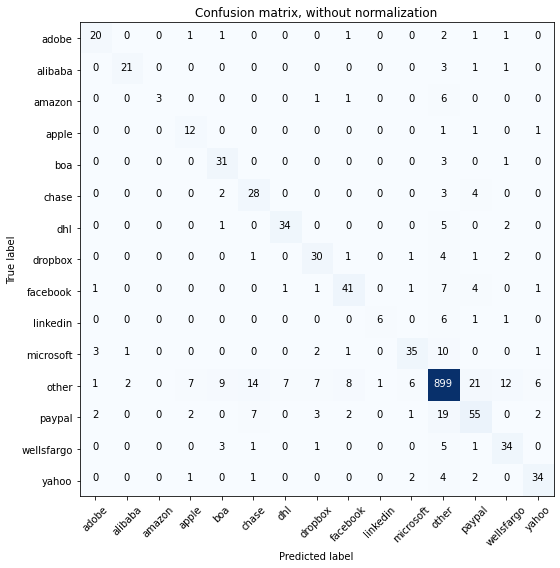

Acc     =  0.834
Pre     =  0.843
Rec     =  0.834
F1      =  0.835

Bal_Acc =  0.71
Bal_Pre =  0.739
Bal_Rec =  0.71
Bal_F1  =  0.724

              precision    recall  f1-score   support

       adobe       0.74      0.74      0.74        27
     alibaba       0.88      0.81      0.84        26
      amazon       1.00      0.27      0.43        11
       apple       0.52      0.80      0.63        15
         boa       0.66      0.89      0.76        35
       chase       0.54      0.76      0.63        37
         dhl       0.81      0.81      0.81        42
     dropbox       0.67      0.75      0.71        40
    facebook       0.75      0.72      0.73        57
    linkedin       0.86      0.43      0.57        14
   microsoft       0.76      0.66      0.71        53
       other       0.92      0.90      0.91      1000
      paypal       0.60      0.59      0.59        93
  wellsfargo       0.63      0.76      0.69        45
       yahoo       0.76      0.77      0.76        44

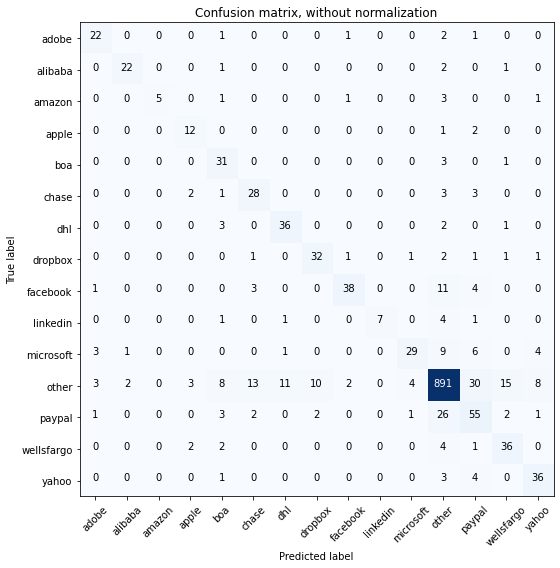

Acc     =  0.832
Pre     =  0.847
Rec     =  0.832
F1      =  0.834

Bal_Acc =  0.735
Bal_Pre =  0.758
Bal_Rec =  0.735
Bal_F1  =  0.746

              precision    recall  f1-score   support

       adobe       0.73      0.81      0.77        27
     alibaba       0.88      0.85      0.86        26
      amazon       1.00      0.45      0.62        11
       apple       0.63      0.80      0.71        15
         boa       0.58      0.89      0.70        35
       chase       0.60      0.76      0.67        37
         dhl       0.73      0.86      0.79        42
     dropbox       0.73      0.80      0.76        40
    facebook       0.88      0.67      0.76        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.83      0.55      0.66        53
       other       0.92      0.89      0.91      1000
      paypal       0.51      0.59      0.55        93
  wellsfargo       0.63      0.80      0.71        45
       yahoo       0.71      0.82      0.76        

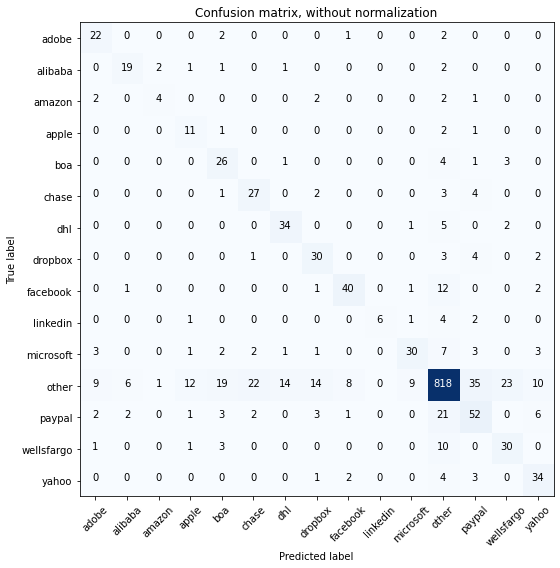

Acc     =  0.769
Pre     =  0.799
Rec     =  0.769
F1      =  0.777

Bal_Acc =  0.679
Bal_Pre =  0.625
Bal_Rec =  0.679
Bal_F1  =  0.651

              precision    recall  f1-score   support

       adobe       0.56      0.81      0.67        27
     alibaba       0.68      0.73      0.70        26
      amazon       0.57      0.36      0.44        11
       apple       0.39      0.73      0.51        15
         boa       0.45      0.74      0.56        35
       chase       0.50      0.73      0.59        37
         dhl       0.67      0.81      0.73        42
     dropbox       0.56      0.75      0.64        40
    facebook       0.77      0.70      0.73        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.71      0.57      0.63        53
       other       0.91      0.82      0.86      1000
      paypal       0.49      0.56      0.52        93
  wellsfargo       0.52      0.67      0.58        45
       yahoo       0.60      0.77      0.67        

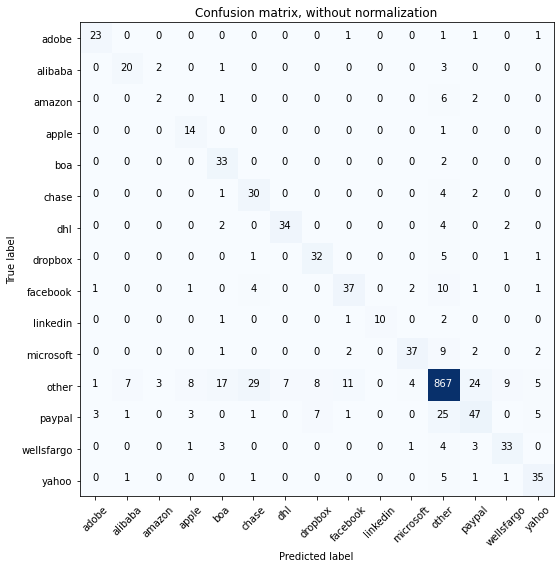

Acc     =  0.815
Pre     =  0.83
Rec     =  0.815
F1      =  0.818

Bal_Acc =  0.737
Bal_Pre =  0.684
Bal_Rec =  0.737
Bal_F1  =  0.71

              precision    recall  f1-score   support

       adobe       0.82      0.85      0.84        27
     alibaba       0.69      0.77      0.73        26
      amazon       0.29      0.18      0.22        11
       apple       0.52      0.93      0.67        15
         boa       0.55      0.94      0.69        35
       chase       0.45      0.81      0.58        37
         dhl       0.83      0.81      0.82        42
     dropbox       0.68      0.80      0.74        40
    facebook       0.70      0.65      0.67        57
    linkedin       1.00      0.71      0.83        14
   microsoft       0.84      0.70      0.76        53
       other       0.91      0.87      0.89      1000
      paypal       0.57      0.51      0.53        93
  wellsfargo       0.72      0.73      0.73        45
       yahoo       0.70      0.80      0.74        44

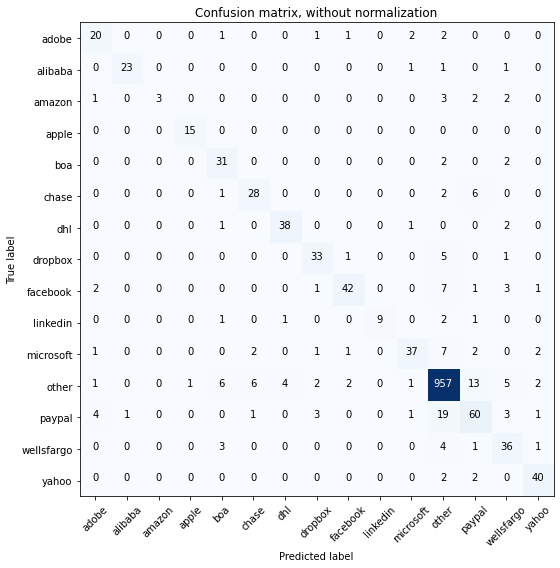

Acc     =  0.891
Pre     =  0.894
Rec     =  0.891
F1      =  0.89

Bal_Acc =  0.777
Bal_Pre =  0.841
Bal_Rec =  0.777
Bal_F1  =  0.808

              precision    recall  f1-score   support

       adobe       0.69      0.74      0.71        27
     alibaba       0.96      0.88      0.92        26
      amazon       1.00      0.27      0.43        11
       apple       0.94      1.00      0.97        15
         boa       0.70      0.89      0.78        35
       chase       0.76      0.76      0.76        37
         dhl       0.88      0.90      0.89        42
     dropbox       0.80      0.82      0.81        40
    facebook       0.89      0.74      0.81        57
    linkedin       1.00      0.64      0.78        14
   microsoft       0.86      0.70      0.77        53
       other       0.94      0.96      0.95      1000
      paypal       0.68      0.65      0.66        93
  wellsfargo       0.65      0.80      0.72        45
       yahoo       0.85      0.91      0.88        4

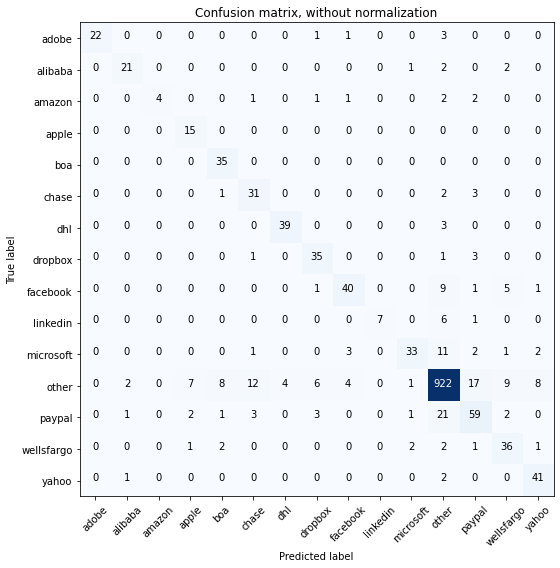

Acc     =  0.871
Pre     =  0.879
Rec     =  0.871
F1      =  0.87

Bal_Acc =  0.783
Bal_Pre =  0.812
Bal_Rec =  0.783
Bal_F1  =  0.797

              precision    recall  f1-score   support

       adobe       1.00      0.81      0.90        27
     alibaba       0.84      0.81      0.82        26
      amazon       1.00      0.36      0.53        11
       apple       0.60      1.00      0.75        15
         boa       0.74      1.00      0.85        35
       chase       0.63      0.84      0.72        37
         dhl       0.91      0.93      0.92        42
     dropbox       0.74      0.88      0.80        40
    facebook       0.82      0.70      0.75        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.87      0.62      0.73        53
       other       0.94      0.92      0.93      1000
      paypal       0.66      0.63      0.65        93
  wellsfargo       0.65      0.80      0.72        45
       yahoo       0.77      0.93      0.85        4

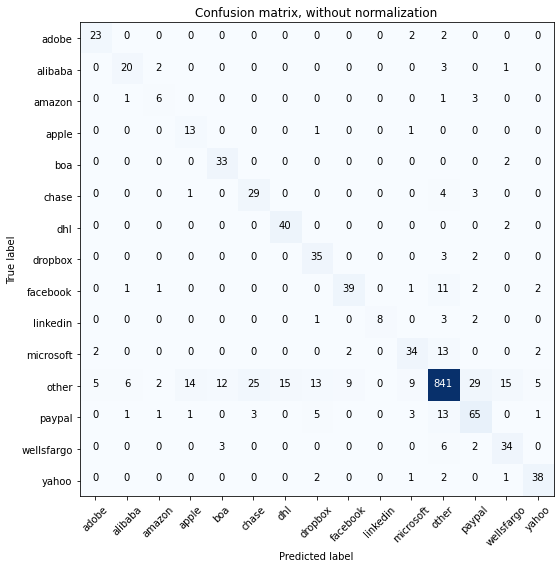

Acc     =  0.817
Pre     =  0.841
Rec     =  0.817
F1      =  0.823

Bal_Acc =  0.776
Bal_Pre =  0.689
Bal_Rec =  0.776
Bal_F1  =  0.73

              precision    recall  f1-score   support

       adobe       0.77      0.85      0.81        27
     alibaba       0.69      0.77      0.73        26
      amazon       0.50      0.55      0.52        11
       apple       0.45      0.87      0.59        15
         boa       0.69      0.94      0.80        35
       chase       0.51      0.78      0.62        37
         dhl       0.73      0.95      0.82        42
     dropbox       0.61      0.88      0.72        40
    facebook       0.78      0.68      0.73        57
    linkedin       1.00      0.57      0.73        14
   microsoft       0.67      0.64      0.65        53
       other       0.93      0.84      0.88      1000
      paypal       0.60      0.70      0.65        93
  wellsfargo       0.62      0.76      0.68        45
       yahoo       0.79      0.86      0.83        4

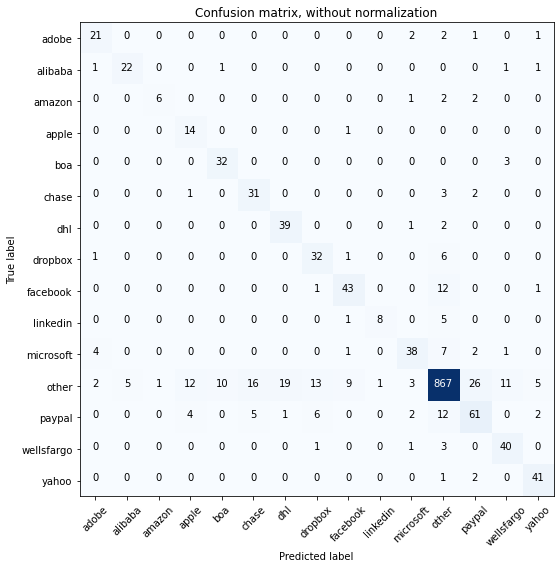

Acc     =  0.841
Pre     =  0.859
Rec     =  0.841
F1      =  0.846

Bal_Acc =  0.798
Bal_Pre =  0.733
Bal_Rec =  0.798
Bal_F1  =  0.764

              precision    recall  f1-score   support

       adobe       0.72      0.78      0.75        27
     alibaba       0.81      0.85      0.83        26
      amazon       0.86      0.55      0.67        11
       apple       0.45      0.93      0.61        15
         boa       0.74      0.91      0.82        35
       chase       0.60      0.84      0.70        37
         dhl       0.66      0.93      0.77        42
     dropbox       0.60      0.80      0.69        40
    facebook       0.77      0.75      0.76        57
    linkedin       0.89      0.57      0.70        14
   microsoft       0.79      0.72      0.75        53
       other       0.94      0.87      0.90      1000
      paypal       0.64      0.66      0.65        93
  wellsfargo       0.71      0.89      0.79        45
       yahoo       0.80      0.93      0.86        

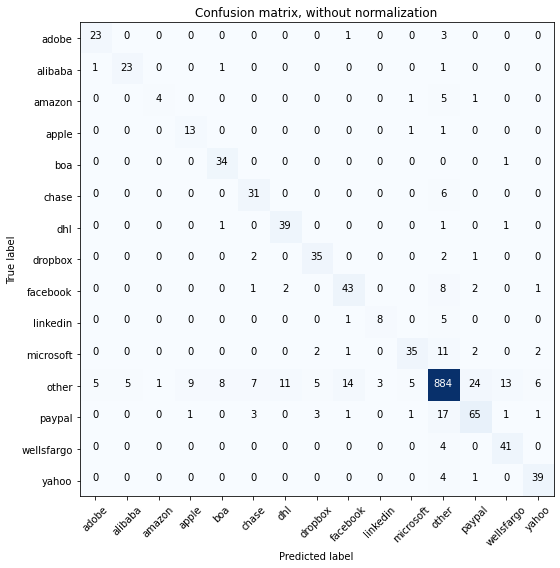

Acc     =  0.856
Pre     =  0.863
Rec     =  0.856
F1      =  0.857

Bal_Acc =  0.796
Bal_Pre =  0.757
Bal_Rec =  0.796
Bal_F1  =  0.776

              precision    recall  f1-score   support

       adobe       0.79      0.85      0.82        27
     alibaba       0.82      0.88      0.85        26
      amazon       0.80      0.36      0.50        11
       apple       0.57      0.87      0.68        15
         boa       0.77      0.97      0.86        35
       chase       0.70      0.84      0.77        37
         dhl       0.75      0.93      0.83        42
     dropbox       0.78      0.88      0.82        40
    facebook       0.70      0.75      0.73        57
    linkedin       0.73      0.57      0.64        14
   microsoft       0.81      0.66      0.73        53
       other       0.93      0.88      0.91      1000
      paypal       0.68      0.70      0.69        93
  wellsfargo       0.72      0.91      0.80        45
       yahoo       0.80      0.89      0.84        

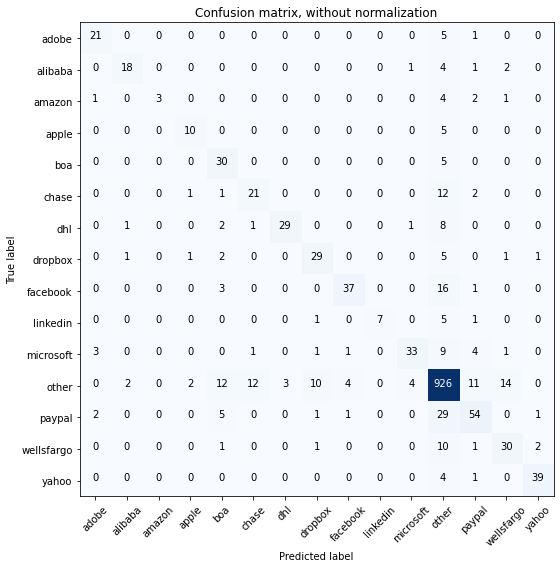

Acc     =  0.836
Pre     =  0.84
Rec     =  0.836
F1      =  0.833

Bal_Acc =  0.672
Bal_Pre =  0.788
Bal_Rec =  0.672
Bal_F1  =  0.725

              precision    recall  f1-score   support

       adobe       0.78      0.78      0.78        27
     alibaba       0.82      0.69      0.75        26
      amazon       1.00      0.27      0.43        11
       apple       0.71      0.67      0.69        15
         boa       0.54      0.86      0.66        35
       chase       0.60      0.57      0.58        37
         dhl       0.91      0.69      0.78        42
     dropbox       0.67      0.72      0.70        40
    facebook       0.86      0.65      0.74        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.85      0.62      0.72        53
       other       0.88      0.93      0.90      1000
      paypal       0.68      0.58      0.63        93
  wellsfargo       0.61      0.67      0.64        45
       yahoo       0.91      0.89      0.90        4

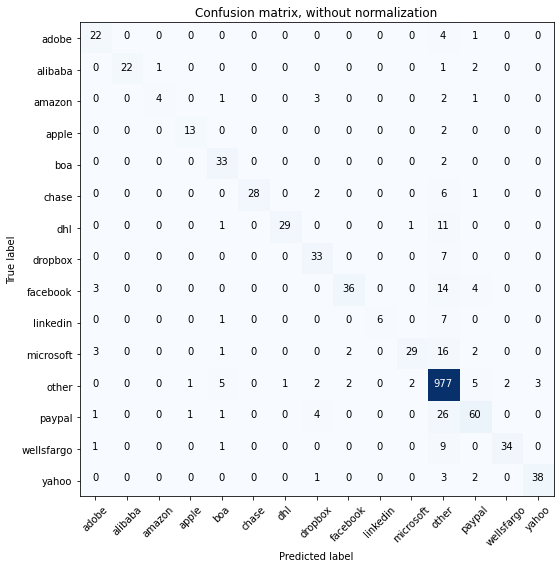

Acc     =  0.886
Pre     =  0.889
Rec     =  0.886
F1      =  0.88

Bal_Acc =  0.73
Bal_Pre =  0.88
Bal_Rec =  0.73
Bal_F1  =  0.798

              precision    recall  f1-score   support

       adobe       0.73      0.81      0.77        27
     alibaba       1.00      0.85      0.92        26
      amazon       0.80      0.36      0.50        11
       apple       0.87      0.87      0.87        15
         boa       0.75      0.94      0.84        35
       chase       1.00      0.76      0.86        37
         dhl       0.97      0.69      0.81        42
     dropbox       0.73      0.82      0.78        40
    facebook       0.90      0.63      0.74        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.91      0.55      0.68        53
       other       0.90      0.98      0.94      1000
      paypal       0.77      0.65      0.70        93
  wellsfargo       0.94      0.76      0.84        45
       yahoo       0.93      0.86      0.89        44



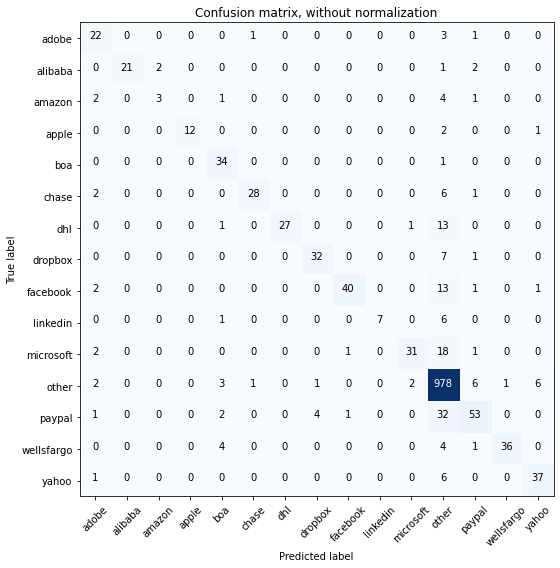

Acc     =  0.884
Pre     =  0.887
Rec     =  0.884
F1      =  0.878

Bal_Acc =  0.723
Bal_Pre =  0.874
Bal_Rec =  0.723
Bal_F1  =  0.791

              precision    recall  f1-score   support

       adobe       0.65      0.81      0.72        27
     alibaba       1.00      0.81      0.89        26
      amazon       0.60      0.27      0.37        11
       apple       1.00      0.80      0.89        15
         boa       0.74      0.97      0.84        35
       chase       0.93      0.76      0.84        37
         dhl       1.00      0.64      0.78        42
     dropbox       0.86      0.80      0.83        40
    facebook       0.95      0.70      0.81        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.91      0.58      0.71        53
       other       0.89      0.98      0.93      1000
      paypal       0.78      0.57      0.66        93
  wellsfargo       0.97      0.80      0.88        45
       yahoo       0.82      0.84      0.83        

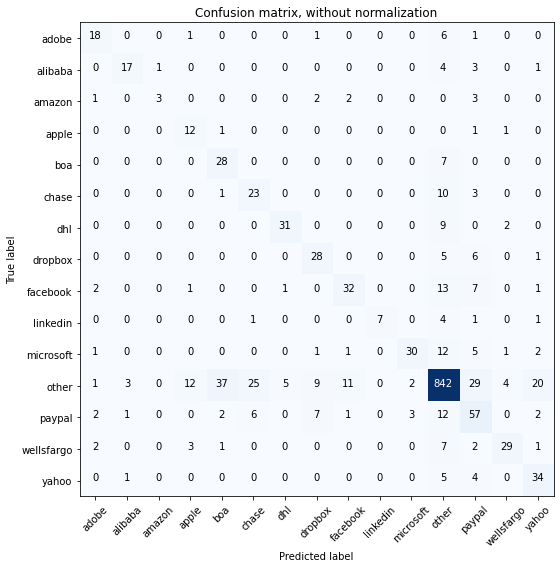

Acc     =  0.774
Pre     =  0.806
Rec     =  0.774
F1      =  0.782

Bal_Acc =  0.65
Bal_Pre =  0.671
Bal_Rec =  0.65
Bal_F1  =  0.66

              precision    recall  f1-score   support

       adobe       0.67      0.67      0.67        27
     alibaba       0.77      0.65      0.71        26
      amazon       0.75      0.27      0.40        11
       apple       0.41      0.80      0.55        15
         boa       0.40      0.80      0.53        35
       chase       0.42      0.62      0.50        37
         dhl       0.84      0.74      0.78        42
     dropbox       0.58      0.70      0.64        40
    facebook       0.68      0.56      0.62        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.86      0.57      0.68        53
       other       0.90      0.84      0.87      1000
      paypal       0.47      0.61      0.53        93
  wellsfargo       0.78      0.64      0.71        45
       yahoo       0.54      0.77      0.64        44


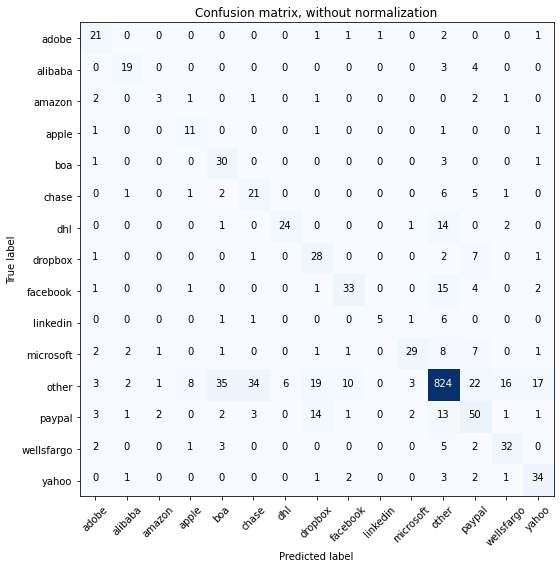

Acc     =  0.756
Pre     =  0.795
Rec     =  0.756
F1      =  0.767

Bal_Acc =  0.636
Bal_Pre =  0.603
Bal_Rec =  0.636
Bal_F1  =  0.619

              precision    recall  f1-score   support

       adobe       0.57      0.78      0.66        27
     alibaba       0.73      0.73      0.73        26
      amazon       0.43      0.27      0.33        11
       apple       0.48      0.73      0.58        15
         boa       0.40      0.86      0.55        35
       chase       0.34      0.57      0.43        37
         dhl       0.80      0.57      0.67        42
     dropbox       0.42      0.70      0.52        40
    facebook       0.69      0.58      0.63        57
    linkedin       0.83      0.36      0.50        14
   microsoft       0.81      0.55      0.65        53
       other       0.91      0.82      0.87      1000
      paypal       0.48      0.54      0.51        93
  wellsfargo       0.59      0.71      0.65        45
       yahoo       0.58      0.77      0.66        

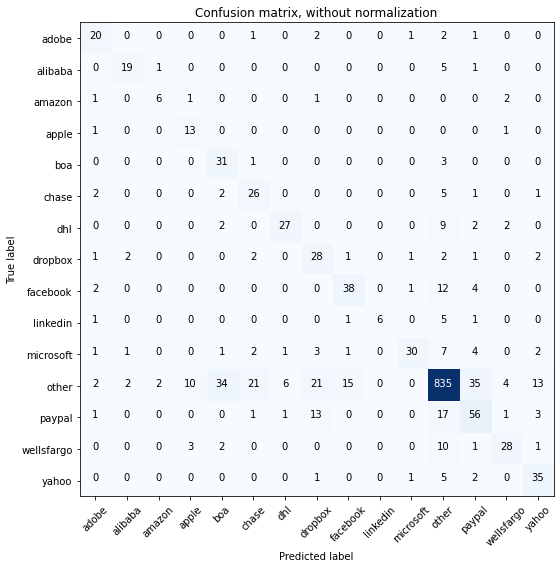

Acc     =  0.778
Pre     =  0.813
Rec     =  0.778
F1      =  0.788

Bal_Acc =  0.689
Bal_Pre =  0.666
Bal_Rec =  0.689
Bal_F1  =  0.677

              precision    recall  f1-score   support

       adobe       0.62      0.74      0.68        27
     alibaba       0.79      0.73      0.76        26
      amazon       0.67      0.55      0.60        11
       apple       0.48      0.87      0.62        15
         boa       0.43      0.89      0.58        35
       chase       0.48      0.70      0.57        37
         dhl       0.77      0.64      0.70        42
     dropbox       0.41      0.70      0.51        40
    facebook       0.68      0.67      0.67        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.88      0.57      0.69        53
       other       0.91      0.83      0.87      1000
      paypal       0.51      0.60      0.55        93
  wellsfargo       0.74      0.62      0.67        45
       yahoo       0.61      0.80      0.69        

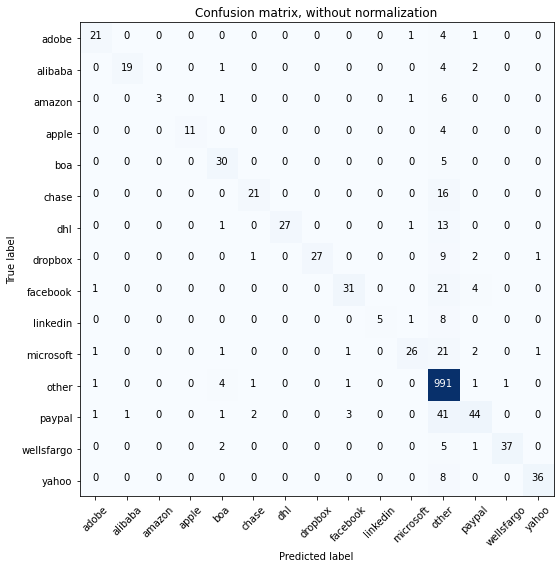

Acc     =  0.864
Pre     =  0.868
Rec     =  0.864
F1      =  0.851

Bal_Acc =  0.65
Bal_Pre =  0.909
Bal_Rec =  0.65
Bal_F1  =  0.758

              precision    recall  f1-score   support

       adobe       0.84      0.78      0.81        27
     alibaba       0.95      0.73      0.83        26
      amazon       1.00      0.27      0.43        11
       apple       1.00      0.73      0.85        15
         boa       0.73      0.86      0.79        35
       chase       0.84      0.57      0.68        37
         dhl       1.00      0.64      0.78        42
     dropbox       1.00      0.68      0.81        40
    facebook       0.86      0.54      0.67        57
    linkedin       1.00      0.36      0.53        14
   microsoft       0.87      0.49      0.63        53
       other       0.86      0.99      0.92      1000
      paypal       0.77      0.47      0.59        93
  wellsfargo       0.97      0.82      0.89        45
       yahoo       0.95      0.82      0.88        44

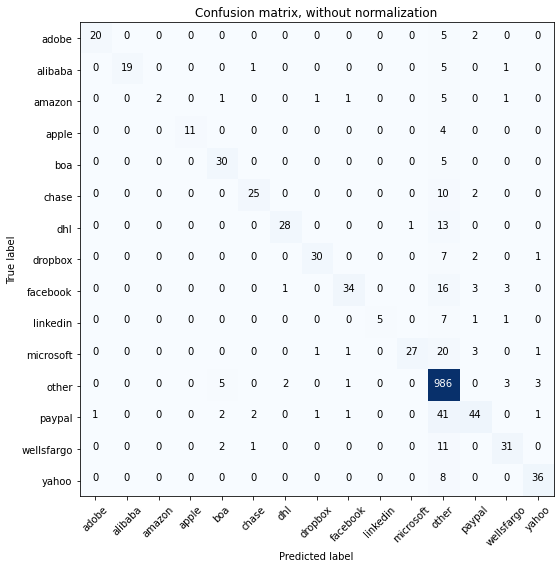

Acc     =  0.863
Pre     =  0.866
Rec     =  0.863
F1      =  0.851

Bal_Acc =  0.651
Bal_Pre =  0.9
Bal_Rec =  0.651
Bal_F1  =  0.756

              precision    recall  f1-score   support

       adobe       0.95      0.74      0.83        27
     alibaba       1.00      0.73      0.84        26
      amazon       1.00      0.18      0.31        11
       apple       1.00      0.73      0.85        15
         boa       0.75      0.86      0.80        35
       chase       0.86      0.68      0.76        37
         dhl       0.90      0.67      0.77        42
     dropbox       0.91      0.75      0.82        40
    facebook       0.89      0.60      0.72        57
    linkedin       1.00      0.36      0.53        14
   microsoft       0.96      0.51      0.67        53
       other       0.86      0.99      0.92      1000
      paypal       0.77      0.47      0.59        93
  wellsfargo       0.78      0.69      0.73        45
       yahoo       0.86      0.82      0.84        44

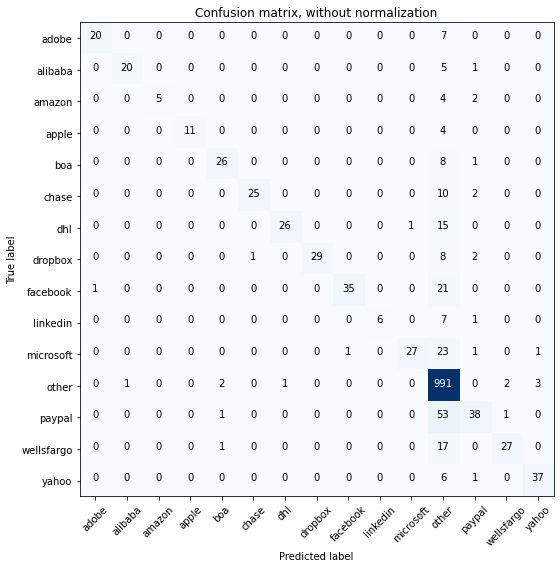

Acc     =  0.86
Pre     =  0.868
Rec     =  0.86
F1      =  0.847

Bal_Acc =  0.657
Bal_Pre =  0.937
Bal_Rec =  0.657
Bal_F1  =  0.772

              precision    recall  f1-score   support

       adobe       0.95      0.74      0.83        27
     alibaba       0.95      0.77      0.85        26
      amazon       1.00      0.45      0.62        11
       apple       1.00      0.73      0.85        15
         boa       0.87      0.74      0.80        35
       chase       0.96      0.68      0.79        37
         dhl       0.96      0.62      0.75        42
     dropbox       1.00      0.72      0.84        40
    facebook       0.97      0.61      0.75        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.96      0.51      0.67        53
       other       0.84      0.99      0.91      1000
      paypal       0.78      0.41      0.54        93
  wellsfargo       0.90      0.60      0.72        45
       yahoo       0.90      0.84      0.87        44

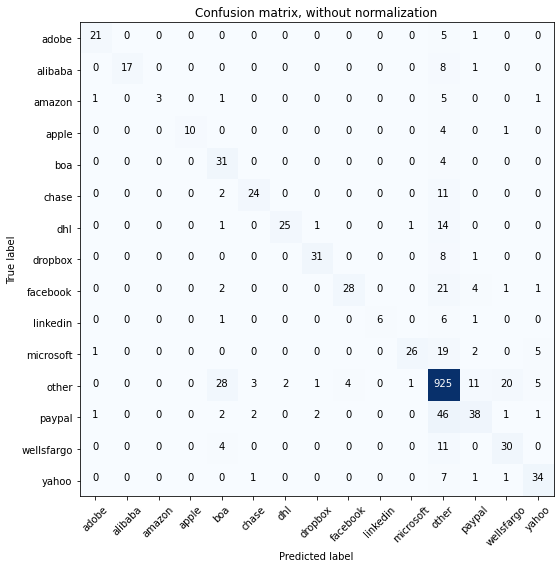

Acc     =  0.812
Pre     =  0.825
Rec     =  0.812
F1      =  0.804

Bal_Acc =  0.631
Bal_Pre =  0.832
Bal_Rec =  0.631
Bal_F1  =  0.718

              precision    recall  f1-score   support

       adobe       0.88      0.78      0.82        27
     alibaba       1.00      0.65      0.79        26
      amazon       1.00      0.27      0.43        11
       apple       1.00      0.67      0.80        15
         boa       0.43      0.89      0.58        35
       chase       0.80      0.65      0.72        37
         dhl       0.93      0.60      0.72        42
     dropbox       0.89      0.78      0.83        40
    facebook       0.88      0.49      0.63        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.93      0.49      0.64        53
       other       0.85      0.93      0.88      1000
      paypal       0.63      0.41      0.50        93
  wellsfargo       0.56      0.67      0.61        45
       yahoo       0.72      0.77      0.75        

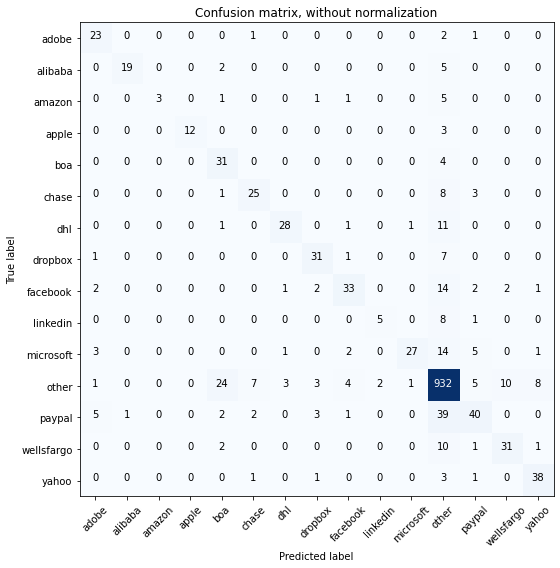

Acc     =  0.83
Pre     =  0.835
Rec     =  0.83
F1      =  0.823

Bal_Acc =  0.668
Bal_Pre =  0.79
Bal_Rec =  0.668
Bal_F1  =  0.724

              precision    recall  f1-score   support

       adobe       0.66      0.85      0.74        27
     alibaba       0.95      0.73      0.83        26
      amazon       1.00      0.27      0.43        11
       apple       1.00      0.80      0.89        15
         boa       0.48      0.89      0.63        35
       chase       0.69      0.68      0.68        37
         dhl       0.85      0.67      0.75        42
     dropbox       0.76      0.78      0.77        40
    facebook       0.77      0.58      0.66        57
    linkedin       0.71      0.36      0.48        14
   microsoft       0.93      0.51      0.66        53
       other       0.88      0.93      0.90      1000
      paypal       0.68      0.43      0.53        93
  wellsfargo       0.72      0.69      0.70        45
       yahoo       0.78      0.86      0.82        44


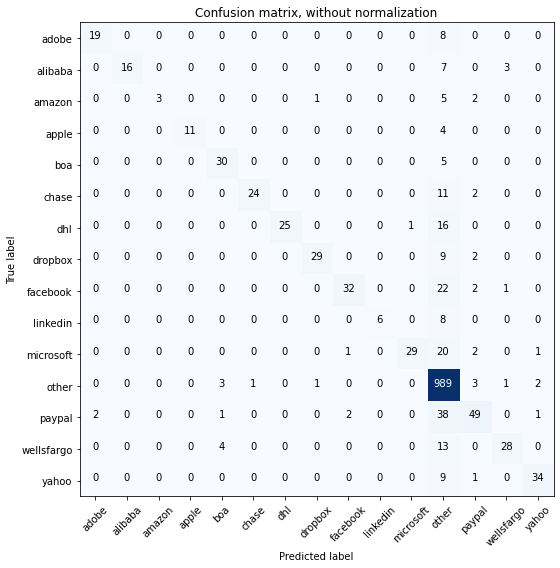

Acc     =  0.86
Pre     =  0.868
Rec     =  0.86
F1      =  0.849

Bal_Acc =  0.64
Bal_Pre =  0.923
Bal_Rec =  0.64
Bal_F1  =  0.756

              precision    recall  f1-score   support

       adobe       0.90      0.70      0.79        27
     alibaba       1.00      0.62      0.76        26
      amazon       1.00      0.27      0.43        11
       apple       1.00      0.73      0.85        15
         boa       0.79      0.86      0.82        35
       chase       0.96      0.65      0.77        37
         dhl       1.00      0.60      0.75        42
     dropbox       0.94      0.72      0.82        40
    facebook       0.91      0.56      0.70        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.97      0.55      0.70        53
       other       0.85      0.99      0.91      1000
      paypal       0.78      0.53      0.63        93
  wellsfargo       0.85      0.62      0.72        45
       yahoo       0.89      0.77      0.83        44



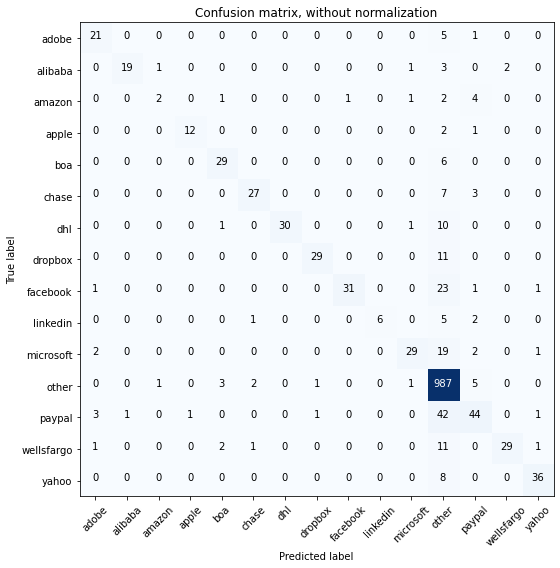

Acc     =  0.865
Pre     =  0.865
Rec     =  0.865
F1      =  0.854

Bal_Acc =  0.662
Bal_Pre =  0.865
Bal_Rec =  0.662
Bal_F1  =  0.75

              precision    recall  f1-score   support

       adobe       0.75      0.78      0.76        27
     alibaba       0.95      0.73      0.83        26
      amazon       0.50      0.18      0.27        11
       apple       0.92      0.80      0.86        15
         boa       0.81      0.83      0.82        35
       chase       0.87      0.73      0.79        37
         dhl       1.00      0.71      0.83        42
     dropbox       0.94      0.72      0.82        40
    facebook       0.97      0.54      0.70        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.88      0.55      0.67        53
       other       0.87      0.99      0.92      1000
      paypal       0.70      0.47      0.56        93
  wellsfargo       0.94      0.64      0.76        45
       yahoo       0.90      0.82      0.86        4

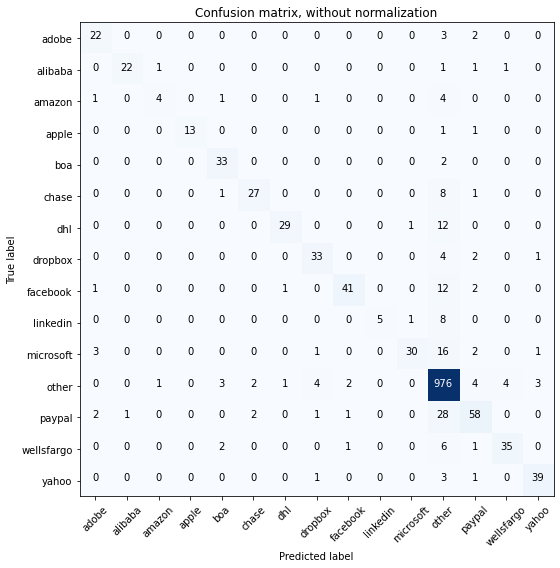

Acc     =  0.888
Pre     =  0.888
Rec     =  0.888
F1      =  0.882

Bal_Acc =  0.732
Bal_Pre =  0.873
Bal_Rec =  0.732
Bal_F1  =  0.796

              precision    recall  f1-score   support

       adobe       0.76      0.81      0.79        27
     alibaba       0.96      0.85      0.90        26
      amazon       0.67      0.36      0.47        11
       apple       1.00      0.87      0.93        15
         boa       0.82      0.94      0.88        35
       chase       0.87      0.73      0.79        37
         dhl       0.94      0.69      0.79        42
     dropbox       0.80      0.82      0.81        40
    facebook       0.91      0.72      0.80        57
    linkedin       1.00      0.36      0.53        14
   microsoft       0.94      0.57      0.71        53
       other       0.90      0.98      0.94      1000
      paypal       0.77      0.62      0.69        93
  wellsfargo       0.88      0.78      0.82        45
       yahoo       0.89      0.89      0.89        

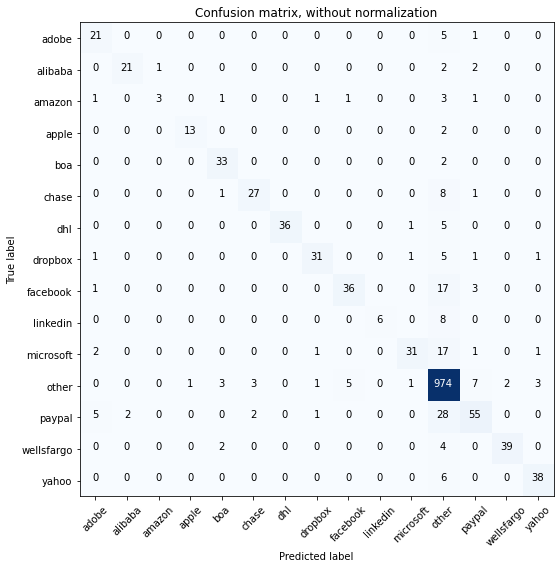

Acc     =  0.886
Pre     =  0.885
Rec     =  0.886
F1      =  0.88

Bal_Acc =  0.731
Bal_Pre =  0.873
Bal_Rec =  0.731
Bal_F1  =  0.796

              precision    recall  f1-score   support

       adobe       0.68      0.78      0.72        27
     alibaba       0.91      0.81      0.86        26
      amazon       0.75      0.27      0.40        11
       apple       0.93      0.87      0.90        15
         boa       0.82      0.94      0.88        35
       chase       0.84      0.73      0.78        37
         dhl       1.00      0.86      0.92        42
     dropbox       0.89      0.78      0.83        40
    facebook       0.86      0.63      0.73        57
    linkedin       1.00      0.43      0.60        14
   microsoft       0.91      0.58      0.71        53
       other       0.90      0.97      0.93      1000
      paypal       0.76      0.59      0.67        93
  wellsfargo       0.95      0.87      0.91        45
       yahoo       0.88      0.86      0.87        4

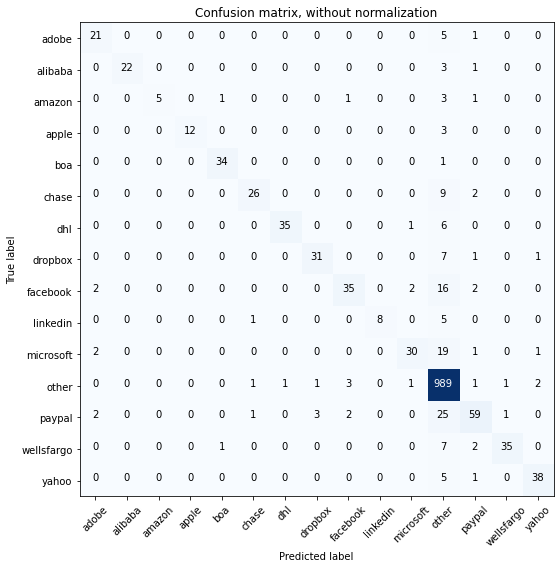

Acc     =  0.897
Pre     =  0.897
Rec     =  0.897
F1      =  0.89

Bal_Acc =  0.745
Bal_Pre =  0.919
Bal_Rec =  0.745
Bal_F1  =  0.823

              precision    recall  f1-score   support

       adobe       0.78      0.78      0.78        27
     alibaba       1.00      0.85      0.92        26
      amazon       1.00      0.45      0.62        11
       apple       1.00      0.80      0.89        15
         boa       0.94      0.97      0.96        35
       chase       0.90      0.70      0.79        37
         dhl       0.97      0.83      0.90        42
     dropbox       0.89      0.78      0.83        40
    facebook       0.85      0.61      0.71        57
    linkedin       1.00      0.57      0.73        14
   microsoft       0.88      0.57      0.69        53
       other       0.90      0.99      0.94      1000
      paypal       0.82      0.63      0.72        93
  wellsfargo       0.95      0.78      0.85        45
       yahoo       0.90      0.86      0.88        4

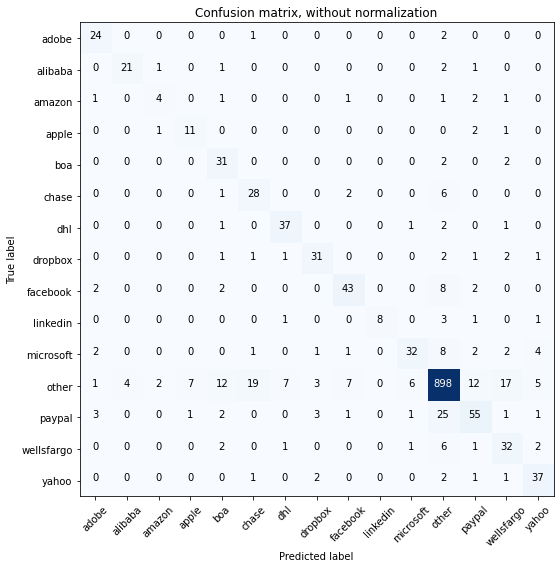

Acc     =  0.84
Pre     =  0.85
Rec     =  0.84
F1      =  0.842

Bal_Acc =  0.738
Bal_Pre =  0.718
Bal_Rec =  0.738
Bal_F1  =  0.728

              precision    recall  f1-score   support

       adobe       0.73      0.89      0.80        27
     alibaba       0.84      0.81      0.82        26
      amazon       0.50      0.36      0.42        11
       apple       0.58      0.73      0.65        15
         boa       0.57      0.89      0.70        35
       chase       0.55      0.76      0.64        37
         dhl       0.79      0.88      0.83        42
     dropbox       0.78      0.78      0.78        40
    facebook       0.78      0.75      0.77        57
    linkedin       1.00      0.57      0.73        14
   microsoft       0.78      0.60      0.68        53
       other       0.93      0.90      0.91      1000
      paypal       0.69      0.59      0.64        93
  wellsfargo       0.53      0.71      0.61        45
       yahoo       0.73      0.84      0.78        44


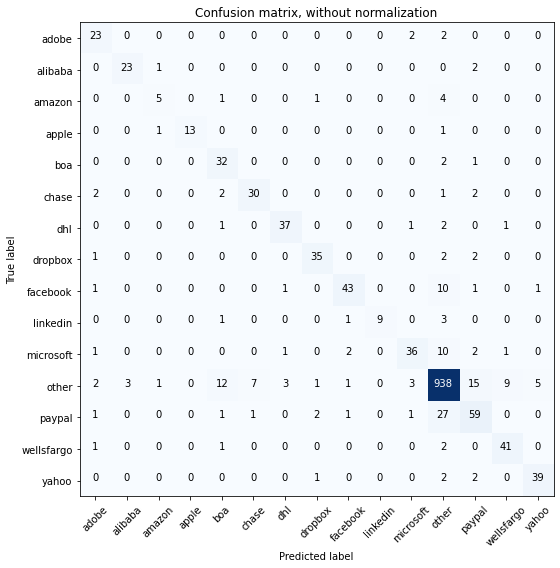

Acc     =  0.886
Pre     =  0.888
Rec     =  0.886
F1      =  0.885

Bal_Acc =  0.799
Bal_Pre =  0.827
Bal_Rec =  0.799
Bal_F1  =  0.813

              precision    recall  f1-score   support

       adobe       0.72      0.85      0.78        27
     alibaba       0.88      0.88      0.88        26
      amazon       0.62      0.45      0.53        11
       apple       1.00      0.87      0.93        15
         boa       0.63      0.91      0.74        35
       chase       0.79      0.81      0.80        37
         dhl       0.88      0.88      0.88        42
     dropbox       0.88      0.88      0.88        40
    facebook       0.90      0.75      0.82        57
    linkedin       1.00      0.64      0.78        14
   microsoft       0.84      0.68      0.75        53
       other       0.93      0.94      0.94      1000
      paypal       0.69      0.63      0.66        93
  wellsfargo       0.79      0.91      0.85        45
       yahoo       0.87      0.89      0.88        

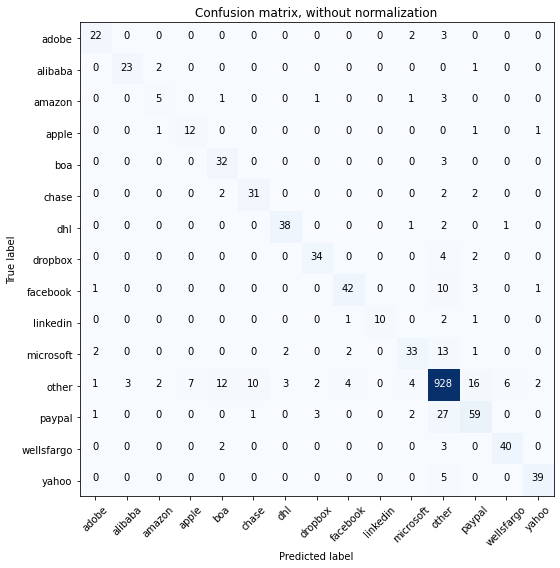

Acc     =  0.876
Pre     =  0.877
Rec     =  0.876
F1      =  0.875

Bal_Acc =  0.791
Bal_Pre =  0.797
Bal_Rec =  0.791
Bal_F1  =  0.794

              precision    recall  f1-score   support

       adobe       0.81      0.81      0.81        27
     alibaba       0.88      0.88      0.88        26
      amazon       0.50      0.45      0.48        11
       apple       0.63      0.80      0.71        15
         boa       0.65      0.91      0.76        35
       chase       0.74      0.84      0.78        37
         dhl       0.88      0.90      0.89        42
     dropbox       0.85      0.85      0.85        40
    facebook       0.86      0.74      0.79        57
    linkedin       1.00      0.71      0.83        14
   microsoft       0.77      0.62      0.69        53
       other       0.92      0.93      0.93      1000
      paypal       0.69      0.63      0.66        93
  wellsfargo       0.85      0.89      0.87        45
       yahoo       0.91      0.89      0.90        

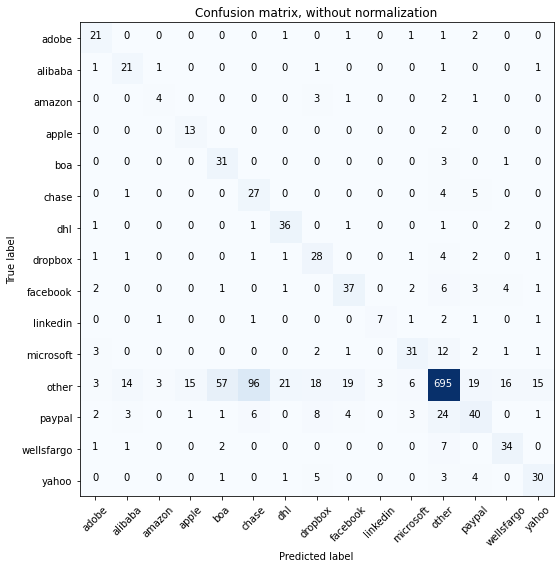

Acc     =  0.686
Pre     =  0.771
Rec     =  0.686
F1      =  0.709

Bal_Acc =  0.686
Bal_Pre =  0.541
Bal_Rec =  0.686
Bal_F1  =  0.605

              precision    recall  f1-score   support

       adobe       0.60      0.78      0.68        27
     alibaba       0.51      0.81      0.63        26
      amazon       0.44      0.36      0.40        11
       apple       0.45      0.87      0.59        15
         boa       0.33      0.89      0.48        35
       chase       0.20      0.73      0.32        37
         dhl       0.59      0.86      0.70        42
     dropbox       0.43      0.70      0.53        40
    facebook       0.58      0.65      0.61        57
    linkedin       0.70      0.50      0.58        14
   microsoft       0.69      0.58      0.63        53
       other       0.91      0.69      0.79      1000
      paypal       0.51      0.43      0.47        93
  wellsfargo       0.59      0.76      0.66        45
       yahoo       0.59      0.68      0.63        

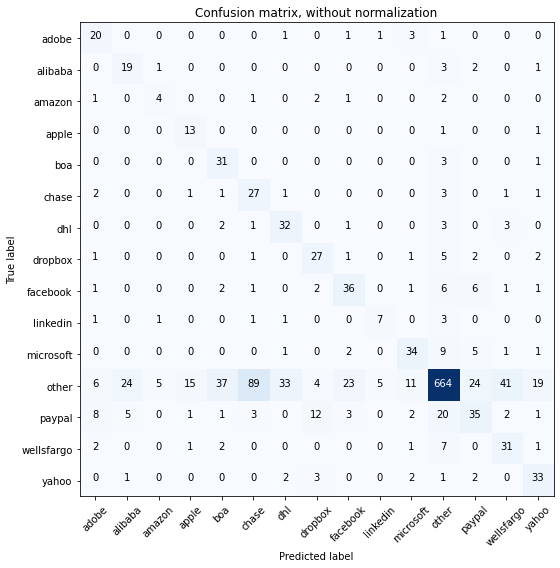

Acc     =  0.658
Pre     =  0.753
Rec     =  0.658
F1      =  0.682

Bal_Acc =  0.667
Bal_Pre =  0.483
Bal_Rec =  0.667
Bal_F1  =  0.56

              precision    recall  f1-score   support

       adobe       0.48      0.74      0.58        27
     alibaba       0.39      0.73      0.51        26
      amazon       0.36      0.36      0.36        11
       apple       0.42      0.87      0.57        15
         boa       0.41      0.89      0.56        35
       chase       0.22      0.73      0.34        37
         dhl       0.45      0.76      0.57        42
     dropbox       0.54      0.68      0.60        40
    facebook       0.53      0.63      0.58        57
    linkedin       0.54      0.50      0.52        14
   microsoft       0.62      0.64      0.63        53
       other       0.91      0.66      0.77      1000
      paypal       0.46      0.38      0.41        93
  wellsfargo       0.39      0.69      0.50        45
       yahoo       0.53      0.75      0.62        4

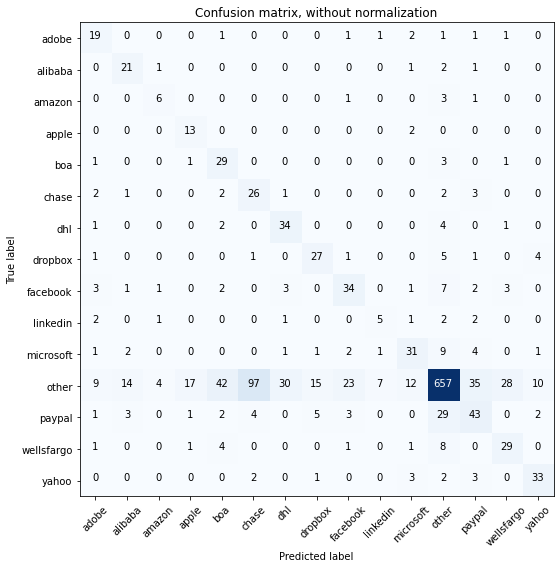

Acc     =  0.654
Pre     =  0.747
Rec     =  0.654
F1      =  0.679

Bal_Acc =  0.666
Bal_Pre =  0.487
Bal_Rec =  0.666
Bal_F1  =  0.563

              precision    recall  f1-score   support

       adobe       0.46      0.70      0.56        27
     alibaba       0.50      0.81      0.62        26
      amazon       0.46      0.55      0.50        11
       apple       0.39      0.87      0.54        15
         boa       0.35      0.83      0.49        35
       chase       0.20      0.70      0.31        37
         dhl       0.49      0.81      0.61        42
     dropbox       0.55      0.68      0.61        40
    facebook       0.52      0.60      0.55        57
    linkedin       0.36      0.36      0.36        14
   microsoft       0.57      0.58      0.58        53
       other       0.90      0.66      0.76      1000
      paypal       0.45      0.46      0.46        93
  wellsfargo       0.46      0.64      0.54        45
       yahoo       0.66      0.75      0.70        

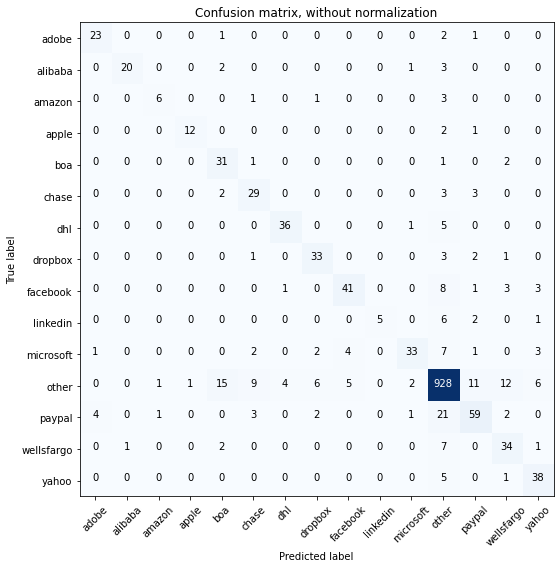

Acc     =  0.863
Pre     =  0.87
Rec     =  0.863
F1      =  0.862

Bal_Acc =  0.747
Bal_Pre =  0.799
Bal_Rec =  0.747
Bal_F1  =  0.772

              precision    recall  f1-score   support

       adobe       0.82      0.85      0.84        27
     alibaba       0.95      0.77      0.85        26
      amazon       0.75      0.55      0.63        11
       apple       0.92      0.80      0.86        15
         boa       0.58      0.89      0.70        35
       chase       0.63      0.78      0.70        37
         dhl       0.88      0.86      0.87        42
     dropbox       0.75      0.82      0.79        40
    facebook       0.82      0.72      0.77        57
    linkedin       1.00      0.36      0.53        14
   microsoft       0.87      0.62      0.73        53
       other       0.92      0.93      0.93      1000
      paypal       0.73      0.63      0.68        93
  wellsfargo       0.62      0.76      0.68        45
       yahoo       0.73      0.86      0.79        4

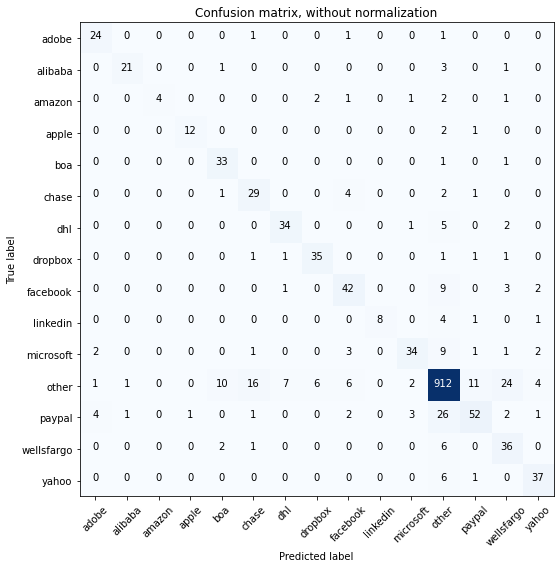

Acc     =  0.853
Pre     =  0.864
Rec     =  0.853
F1      =  0.854

Bal_Acc =  0.756
Bal_Pre =  0.8
Bal_Rec =  0.756
Bal_F1  =  0.777

              precision    recall  f1-score   support

       adobe       0.77      0.89      0.83        27
     alibaba       0.91      0.81      0.86        26
      amazon       1.00      0.36      0.53        11
       apple       0.92      0.80      0.86        15
         boa       0.70      0.94      0.80        35
       chase       0.58      0.78      0.67        37
         dhl       0.79      0.81      0.80        42
     dropbox       0.81      0.88      0.84        40
    facebook       0.71      0.74      0.72        57
    linkedin       1.00      0.57      0.73        14
   microsoft       0.83      0.64      0.72        53
       other       0.92      0.91      0.92      1000
      paypal       0.75      0.56      0.64        93
  wellsfargo       0.50      0.80      0.62        45
       yahoo       0.79      0.84      0.81        44

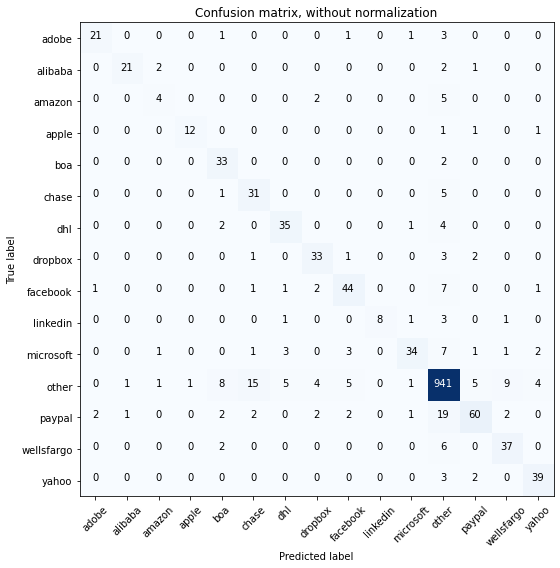

Acc     =  0.879
Pre     =  0.883
Rec     =  0.879
F1      =  0.878

Bal_Acc =  0.765
Bal_Pre =  0.802
Bal_Rec =  0.765
Bal_F1  =  0.783

              precision    recall  f1-score   support

       adobe       0.88      0.78      0.82        27
     alibaba       0.91      0.81      0.86        26
      amazon       0.50      0.36      0.42        11
       apple       0.92      0.80      0.86        15
         boa       0.67      0.94      0.79        35
       chase       0.61      0.84      0.70        37
         dhl       0.78      0.83      0.80        42
     dropbox       0.77      0.82      0.80        40
    facebook       0.79      0.77      0.78        57
    linkedin       1.00      0.57      0.73        14
   microsoft       0.87      0.64      0.74        53
       other       0.93      0.94      0.94      1000
      paypal       0.83      0.65      0.73        93
  wellsfargo       0.74      0.82      0.78        45
       yahoo       0.83      0.89      0.86        

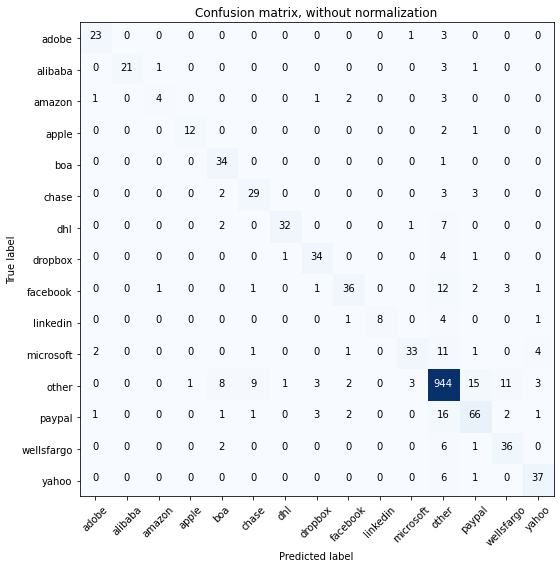

Acc     =  0.877
Pre     =  0.879
Rec     =  0.877
F1      =  0.874

Bal_Acc =  0.754
Bal_Pre =  0.827
Bal_Rec =  0.754
Bal_F1  =  0.789

              precision    recall  f1-score   support

       adobe       0.85      0.85      0.85        27
     alibaba       1.00      0.81      0.89        26
      amazon       0.67      0.36      0.47        11
       apple       0.92      0.80      0.86        15
         boa       0.69      0.97      0.81        35
       chase       0.71      0.78      0.74        37
         dhl       0.94      0.76      0.84        42
     dropbox       0.81      0.85      0.83        40
    facebook       0.82      0.63      0.71        57
    linkedin       1.00      0.57      0.73        14
   microsoft       0.87      0.62      0.73        53
       other       0.92      0.94      0.93      1000
      paypal       0.72      0.71      0.71        93
  wellsfargo       0.69      0.80      0.74        45
       yahoo       0.79      0.84      0.81        

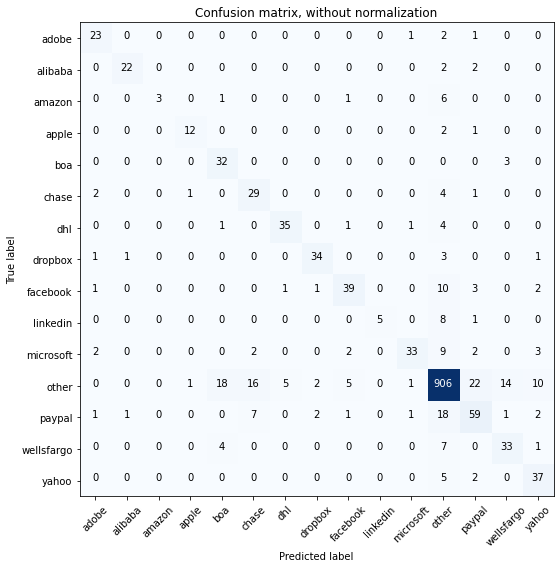

Acc     =  0.846
Pre     =  0.858
Rec     =  0.846
F1      =  0.846

Bal_Acc =  0.729
Bal_Pre =  0.794
Bal_Rec =  0.729
Bal_F1  =  0.76

              precision    recall  f1-score   support

       adobe       0.77      0.85      0.81        27
     alibaba       0.92      0.85      0.88        26
      amazon       1.00      0.27      0.43        11
       apple       0.86      0.80      0.83        15
         boa       0.57      0.91      0.70        35
       chase       0.54      0.78      0.64        37
         dhl       0.85      0.83      0.84        42
     dropbox       0.87      0.85      0.86        40
    facebook       0.80      0.68      0.74        57
    linkedin       1.00      0.36      0.53        14
   microsoft       0.89      0.62      0.73        53
       other       0.92      0.91      0.91      1000
      paypal       0.63      0.63      0.63        93
  wellsfargo       0.65      0.73      0.69        45
       yahoo       0.66      0.84      0.74        4

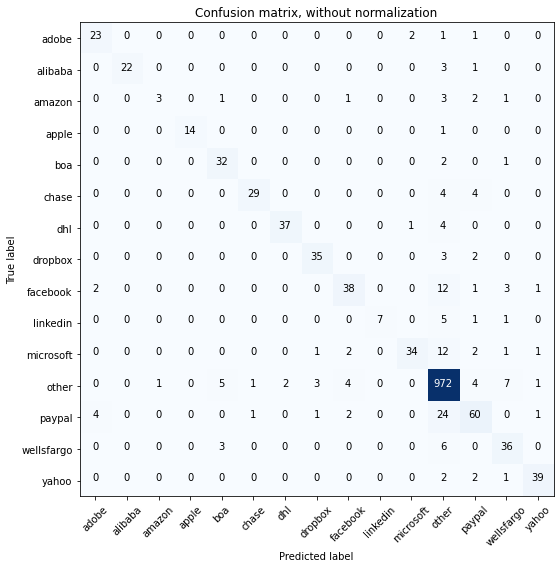

Acc     =  0.897
Pre     =  0.897
Rec     =  0.897
F1      =  0.893

Bal_Acc =  0.765
Bal_Pre =  0.873
Bal_Rec =  0.765
Bal_F1  =  0.815

              precision    recall  f1-score   support

       adobe       0.79      0.85      0.82        27
     alibaba       1.00      0.85      0.92        26
      amazon       0.75      0.27      0.40        11
       apple       1.00      0.93      0.97        15
         boa       0.78      0.91      0.84        35
       chase       0.94      0.78      0.85        37
         dhl       0.95      0.88      0.91        42
     dropbox       0.88      0.88      0.88        40
    facebook       0.81      0.67      0.73        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.92      0.64      0.76        53
       other       0.92      0.97      0.95      1000
      paypal       0.75      0.65      0.69        93
  wellsfargo       0.71      0.80      0.75        45
       yahoo       0.91      0.89      0.90        

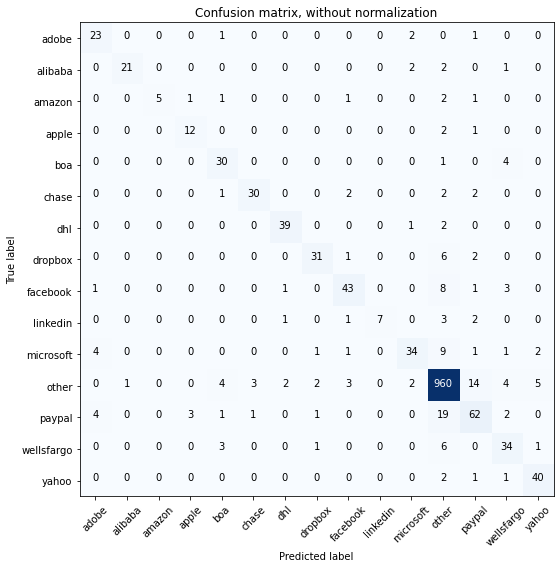

Acc     =  0.891
Pre     =  0.892
Rec     =  0.891
F1      =  0.889

Bal_Acc =  0.765
Bal_Pre =  0.841
Bal_Rec =  0.765
Bal_F1  =  0.801

              precision    recall  f1-score   support

       adobe       0.72      0.85      0.78        27
     alibaba       0.95      0.81      0.88        26
      amazon       1.00      0.45      0.62        11
       apple       0.75      0.80      0.77        15
         boa       0.73      0.86      0.79        35
       chase       0.88      0.81      0.85        37
         dhl       0.91      0.93      0.92        42
     dropbox       0.86      0.78      0.82        40
    facebook       0.83      0.75      0.79        57
    linkedin       1.00      0.50      0.67        14
   microsoft       0.83      0.64      0.72        53
       other       0.94      0.96      0.95      1000
      paypal       0.70      0.67      0.69        93
  wellsfargo       0.68      0.76      0.72        45
       yahoo       0.83      0.91      0.87        

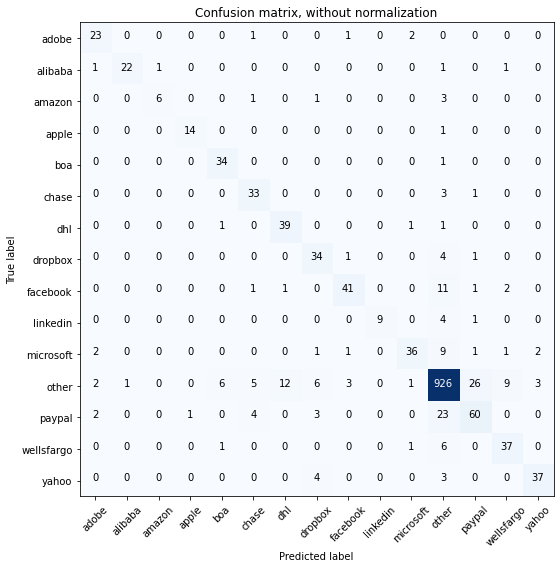

Acc     =  0.878
Pre     =  0.882
Rec     =  0.878
F1      =  0.878

Bal_Acc =  0.806
Bal_Pre =  0.831
Bal_Rec =  0.806
Bal_F1  =  0.818

              precision    recall  f1-score   support

       adobe       0.77      0.85      0.81        27
     alibaba       0.96      0.85      0.90        26
      amazon       0.86      0.55      0.67        11
       apple       0.93      0.93      0.93        15
         boa       0.81      0.97      0.88        35
       chase       0.73      0.89      0.80        37
         dhl       0.75      0.93      0.83        42
     dropbox       0.69      0.85      0.76        40
    facebook       0.87      0.72      0.79        57
    linkedin       1.00      0.64      0.78        14
   microsoft       0.88      0.68      0.77        53
       other       0.93      0.93      0.93      1000
      paypal       0.66      0.65      0.65        93
  wellsfargo       0.74      0.82      0.78        45
       yahoo       0.88      0.84      0.86        

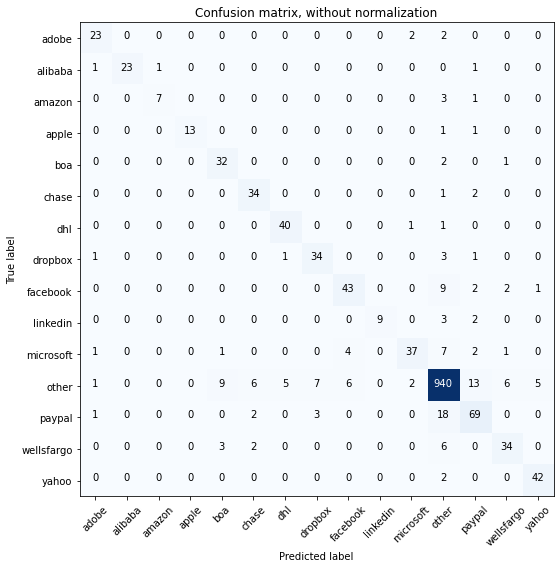

Acc     =  0.897
Pre     =  0.899
Rec     =  0.897
F1      =  0.896

Bal_Acc =  0.824
Bal_Pre =  0.856
Bal_Rec =  0.824
Bal_F1  =  0.84

              precision    recall  f1-score   support

       adobe       0.82      0.85      0.84        27
     alibaba       1.00      0.88      0.94        26
      amazon       0.88      0.64      0.74        11
       apple       1.00      0.87      0.93        15
         boa       0.71      0.91      0.80        35
       chase       0.77      0.92      0.84        37
         dhl       0.87      0.95      0.91        42
     dropbox       0.77      0.85      0.81        40
    facebook       0.81      0.75      0.78        57
    linkedin       1.00      0.64      0.78        14
   microsoft       0.88      0.70      0.78        53
       other       0.94      0.94      0.94      1000
      paypal       0.73      0.74      0.74        93
  wellsfargo       0.77      0.76      0.76        45
       yahoo       0.88      0.95      0.91        4

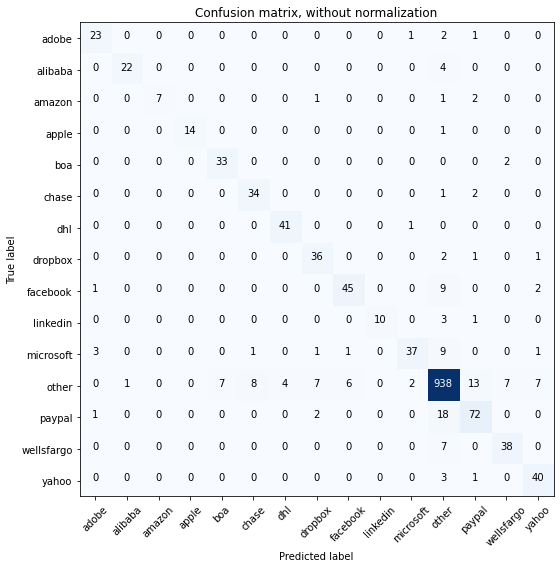

Acc     =  0.903
Pre     =  0.906
Rec     =  0.903
F1      =  0.903

Bal_Acc =  0.845
Bal_Pre =  0.876
Bal_Rec =  0.845
Bal_F1  =  0.86

              precision    recall  f1-score   support

       adobe       0.82      0.85      0.84        27
     alibaba       0.96      0.85      0.90        26
      amazon       1.00      0.64      0.78        11
       apple       1.00      0.93      0.97        15
         boa       0.82      0.94      0.88        35
       chase       0.79      0.92      0.85        37
         dhl       0.91      0.98      0.94        42
     dropbox       0.77      0.90      0.83        40
    facebook       0.87      0.79      0.83        57
    linkedin       1.00      0.71      0.83        14
   microsoft       0.90      0.70      0.79        53
       other       0.94      0.94      0.94      1000
      paypal       0.77      0.77      0.77        93
  wellsfargo       0.81      0.84      0.83        45
       yahoo       0.78      0.91      0.84        4

[['RF',
  'Xception',
  128,
  0.802,
  0.81,
  0.802,
  0.802,
  0.644,
  0.659,
  0.644,
  0.651,
  0.979,
  0.978,
  0.021,
  0.356,
  0.341,
  0.974],
 ['RF',
  'VGG16',
  128,
  0.885,
  0.887,
  0.885,
  0.88,
  0.721,
  0.84,
  0.721,
  0.776,
  0.985,
  0.989,
  0.015,
  0.279,
  0.16,
  0.985],
 ['RF',
  'VGG19',
  128,
  0.862,
  0.862,
  0.862,
  0.858,
  0.725,
  0.798,
  0.725,
  0.76,
  0.983,
  0.986,
  0.017,
  0.275,
  0.202,
  0.982],
 ['RF',
  'ResNet50',
  128,
  0.761,
  0.802,
  0.761,
  0.772,
  0.665,
  0.652,
  0.665,
  0.658,
  0.976,
  0.973,
  0.024,
  0.335,
  0.348,
  0.968],
 ['RF',
  'ResNet101',
  128,
  0.762,
  0.79,
  0.762,
  0.769,
  0.641,
  0.666,
  0.641,
  0.653,
  0.976,
  0.973,
  0.024,
  0.359,
  0.334,
  0.968],
 ['RF',
  'ResNet152',
  128,
  0.751,
  0.78,
  0.751,
  0.759,
  0.612,
  0.6,
  0.612,
  0.606,
  0.975,
  0.972,
  0.025,
  0.388,
  0.4,
  0.967],
 ['RF',
  'ResNet50V2',
  128,
  0.851,
  0.853,
  0.851,
  0.842,
  0.664,
  0

In [12]:
list_of_analysis=[]
for image_size in list_of_size:
    for classifier in list_of_classifiers:
        for model in list_of_architectures:
            print("--------------------------------------------------------------------------")
            print(classifier + " - " + model + " - " + str(image_size))
            print("")
            accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc = classify(model, classifier, image_size)
            list_of_analysis.append(
                [
                 classifier, model, image_size, accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc
                ]
            )
list_of_analysis

In [13]:
list_of_analysis

[['RF',
  'Xception',
  128,
  0.802,
  0.81,
  0.802,
  0.802,
  0.644,
  0.659,
  0.644,
  0.651,
  0.979,
  0.978,
  0.021,
  0.356,
  0.341,
  0.974],
 ['RF',
  'VGG16',
  128,
  0.885,
  0.887,
  0.885,
  0.88,
  0.721,
  0.84,
  0.721,
  0.776,
  0.985,
  0.989,
  0.015,
  0.279,
  0.16,
  0.985],
 ['RF',
  'VGG19',
  128,
  0.862,
  0.862,
  0.862,
  0.858,
  0.725,
  0.798,
  0.725,
  0.76,
  0.983,
  0.986,
  0.017,
  0.275,
  0.202,
  0.982],
 ['RF',
  'ResNet50',
  128,
  0.761,
  0.802,
  0.761,
  0.772,
  0.665,
  0.652,
  0.665,
  0.658,
  0.976,
  0.973,
  0.024,
  0.335,
  0.348,
  0.968],
 ['RF',
  'ResNet101',
  128,
  0.762,
  0.79,
  0.762,
  0.769,
  0.641,
  0.666,
  0.641,
  0.653,
  0.976,
  0.973,
  0.024,
  0.359,
  0.334,
  0.968],
 ['RF',
  'ResNet152',
  128,
  0.751,
  0.78,
  0.751,
  0.759,
  0.612,
  0.6,
  0.612,
  0.606,
  0.975,
  0.972,
  0.025,
  0.388,
  0.4,
  0.967],
 ['RF',
  'ResNet50V2',
  128,
  0.851,
  0.853,
  0.851,
  0.842,
  0.664,
  0

In [14]:
import pandas as pd
df=pd.DataFrame(list_of_analysis, columns=[
                 "classifier",
                 "model",
                 "image_size",
                 "accuracy", 
                 "precision", 
                 "recall", 
                 "f1_score", 
                 "balanced_accuracy", 
                 "balanced_precision_PPV", 
                 "balanced_recall_TPR", 
                 "Bal_F1",
                 "TNR", 
                 "NPV", 
                 "FPR", 
                 "FNR", 
                 "FDR", 
                 "Overall_Acc"
                ])
df

,classifier,model,image_size,accuracy,precision,recall,f1_score,balanced_accuracy,balanced_precision_PPV,balanced_recall_TPR,Bal_F1,TNR,NPV,FPR,FNR,FDR,Overall_Acc
0,RF,Xception,128,0.802,0.810,0.802,0.802,0.644,0.659,0.644,0.651,0.979,0.978,0.021,0.356,0.341,0.974
1,RF,VGG16,128,0.885,0.887,0.885,0.880,0.721,0.840,0.721,0.776,0.985,0.989,0.015,0.279,0.160,0.985
2,RF,VGG19,128,0.862,0.862,0.862,0.858,0.725,0.798,0.725,0.760,0.983,0.986,0.017,0.275,0.202,0.982
3,RF,ResNet50,128,0.761,0.802,0.761,0.772,0.665,0.652,0.665,0.658,0.976,0.973,0.024,0.335,0.348,0.968
4,RF,ResNet101,128,0.762,0.790,0.762,0.769,0.641,0.666,0.641,0.653,0.976,0.973,0.024,0.359,0.334,0.968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,SVM,MobileNet,256,0.897,0.897,0.897,0.893,0.765,0.873,0.765,0.815,0.986,0.990,0.014,0.235,0.127,0.986
60,SVM,MobileNetV2,256,0.891,0.892,0.891,0.889,0.765,0.841,0.765,0.801,0.987,0.989,0.013,0.235,0.159,0.985
61,SVM,DenseNet121,256,0.878,0.882,0.878,0.878,0.806,0.831,0.806,0.818,0.986,0.986,0.014,0.194,0.169,0.984
62,SVM,DenseNet169,256,0.897,0.899,0.897,0.896,0.824,0.856,0.824,0.840,0.988,0.988,0.012,0.176,0.144,0.986


In [15]:
df.to_csv(analysis_output, header=True, index=False)